<a href="https://colab.research.google.com/github/MarkovMarkowitz/MarkovMarkowitz/blob/main/ON1_Trading_Strategy_Functions_v10_BIST100_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install pyfolio
!pip install datetime

# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

In [ ]:
import os
import pandas_datareader.data as web
from datetime import datetime
from pprint import pprint
import pandas as pd

import datetime
import pyfolio as pyf
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)

current_date = datetime.datetime.now()

delta = 1
day = current_date.day
month = current_date.month
year = current_date.year - delta

COMISSION_PERCENT = 0.00

START = f'{year}-{month}-{day}'
END = f'{year+delta}-{month}-{day}'

TARGET_RETURN = 0.00
VOLATILITY_FACTOR = 0.45

WINNER_LIMIT_TR = 0.54
WINNER_LIMIT_US = 0.51
R_WINDOW = 32
REVERSED = False
LEFT, RIGHT = datetime.date(year, month, day), datetime.date(year+delta, month, day)

Ticker = "EREGL"    # EREGL, ASELS, KCHOL THYAO akşam al sabah sata uygun
TickerIS = Ticker + ".IS"

TR_Tickers = ["EREGL", "CANTE", "GARAN", "KCHOL", "EUPWR"]
US_Tickers = ["TSLA", "AAPL", "GOOGL", "BA", "V"]
DOW30 = ["AXP","AMGN","AAPL","BA","CAT","CSCO","CVX","GS","HD","HON","IBM","JNJ","KO","JPM",
         "MCD","MMM","MRK","MSFT","NKE","PG","TRV","UNH","CRM","VZ","V","WBA","WMT","DIS","DOW"]

BIST30 = ["XU100","AKBNK","ALARK","ARCLK","ASELS","BIMAS","EKGYO","ENKAI","EREGL","FROTO","GARAN",
          "GUBRF","HEKTS","ISCTR","KOZAA","KOZAL","KRDMD","ODAS","PETKM","PGSUS","SAHOL","SASA",
          "SISE","TAVHL","TCELL","THYAO","TOASO","TUPRS","YKBNK","EUPWR"]

BIST100 = ["AKBNK","ALARK","ARCLK","ASELS","BIMAS","EKGYO","ENKAI","EREGL","FROTO","GARAN",
          "GUBRF","HEKTS","ISCTR","KOZAA","KOZAL","KRDMD","ODAS","PETKM","PGSUS","SAHOL","SASA",
          "SISE","TAVHL","TCELL","THYAO","TOASO","TUPRS","YKBNK",
          "AEFES","AGHOL","AHGAZ","AKCNS","AKFGY","AKSA","AKSEN",
           "ALBRK","ASUZU","AYDEM","BAGFS","BERA",
           "BRSAN","BRYAT","BUCIM","CANTE","CCOLA","CEMTS","CIMSA",
           "DOAS","DOHOL","ECILC","ECZYT","EGEEN","ENJSA",
           "GENIL","GESAN","GLYHO","GSDHO","GWIND","HALKB","IPEKE",
           "ISDMR","ISGYO","ISMEN","IZMDC","KARSN","KMPUR",
           "KONTR","KONYA","KORDS","KZBGY","MAVI","OTKAR","OYAKC",
           "PENTA","QUAGR","SELEC","SKBNK","SMRTG",
           "SNGYO","SOKM","TAVHL","TKFEN","TKNSA","TOASO","TSKB",
           "TTKOM","TTRAK","TUKAS","ULKER","VAKBN","VESBE","ZOREN",
           "EUPWR"]


sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

sp500_constituents = pd.read_html(sp_url, header=0)[0]
sp500_constituents = sp500_constituents[sp500_constituents.Symbol != "BRK.B"]
sp500_constituents = sp500_constituents[sp500_constituents.Symbol != "BF.B"]


sp500_constituents.Symbol

0        MMM
1        AOS
2        ABT
3       ABBV
4        ACN
5       ATVI
6        ADM
7       ADBE
8        ADP
9        AAP
10       AES
11       AFL
12         A
13       APD
14      AKAM
15       ALK
16       ALB
17       ARE
18      ALGN
19      ALLE
20       LNT
21       ALL
22     GOOGL
23      GOOG
24        MO
25      AMZN
26      AMCR
27       AMD
28       AEE
29       AAL
30       AEP
31       AXP
32       AIG
33       AMT
34       AWK
35       AMP
36       ABC
37       AME
38      AMGN
39       APH
40       ADI
41      ANSS
42       AON
43       APA
44      AAPL
45      AMAT
46      APTV
47      ACGL
48      ANET
49       AJG
50       AIZ
51         T
52       ATO
53      ADSK
54       AZO
55       AVB
56       AVY
57      AXON
58       BKR
59      BALL
60       BAC
61      BBWI
62       BAX
63       BDX
64       WRB
66       BBY
67       BIO
68      TECH
69      BIIB
70       BLK
71        BK
72        BA
73      BKNG
74       BWA
75       BXP
76       BSX
77       BMY

In [ ]:
def ConvertToUSD(ticker, start, end, exchange):

  try:
      adjclose = yf.download(ticker,start,end)['Adj Close']
      close = yf.download(ticker,start,end)['Close']
      open = yf.download(ticker,start,end)['Open']
      usdtry = yf.download('TRY=X',start,end)['Adj Close']
  except Exception as e:
      print(e)

  adjusted_factor = adjclose / close
  adjopen = adjusted_factor * open


  if ( exchange != "SP500" or exchange != "DOW30"):
    for i in np.arange(0,len(close)):
        adjclose[i] = close[i]/usdtry[i]
        adjopen[i] = open[i]/usdtry[i]

  rets = adjclose.pct_change()

  return adjclose, adjopen, rets

In [ ]:
def UpdateData(TickerIS, START, END, exchange):

  # For data manupulations

  # VF    LB    PEAK_CUM  CUM_LAST    REVERSED
  # 0.25  45    6.11       4.29 OK    True
  # 0.35  45    7.42       5.02 OK    True
  # 0.40  45    7.64       5.17 OK    True
  # 0.45  45    8.99       6.16 OK    True
  # 0.45  45    1.22       1.05 OK    False
  # 0.45  55    7.97       5.39 OK    True
  # 0.45  40    9.35       6.31 OK    True
  # 0.45  35    9.65       7.14 OK    True
  # 0.45  33    9.78       7.24 OK    True  ***
  # 0.45  32    10.02      7.42 OK    True  ****
  # 0.45  30    9.16       6.78 OK    True
  # 0.45  25    8.19       5.98 OK    True
  # -   -       5.17       4.82 OK    True / original Gap up buy side.

  # Read data from Yahoo finance
  data = pd.DataFrame()

  if ( exchange != "SP500" or exchange != "DOW30"):
    # In Turkish exchange
      data['Adj Close'], data['Adj Open'], data['rets'] = ConvertToUSD(TickerIS, START, END, "BIST")
  else:
    # In US exchange
      data['Adj Close'], data['Adj Open'], data['rets'] = ConvertToUSD(TickerIS, START, END, "DOW30")

  data.index = pd.to_datetime(data.index,format="%d-%m-%Y")
  # Buy at Close - Sell at Open (BACSAO) Strategy
  data['returns'] = (data['Adj Open'] - data['Adj Close'].shift(1)) / data['Adj Close'].shift(1) - COMISSION_PERCENT
  data['BAC_SAO_str_returns'] = (data.returns+1).cumprod()


 # Improved Gap-up Strategy
  data['std'] = data['returns'].rolling(R_WINDOW).std()
  data['positions'] = np.nan
  data['close']= data['Adj Close']
  data["log_returns"] = data['close'].pct_change().apply(lambda x: np.log(1+x))
  data["rel"]= data['Adj Close'] / data['Adj Close'][0]

  # Long entry condition
  if REVERSED:
      long_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
      short_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
  else:
  # Short entry condition
      long_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
      short_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']

  # Store 1 when long entry condition is true
  data.loc[long_entry, 'positions'] = 1
  data.loc[short_entry, 'positions'] = 0

  data = data.dropna()

  data['positions'].fillna(method='ffill', inplace=True)

  # BAOSAC STRATEGY: Buy at open, sell at Close
  data['strategy_returns'] = ((data['Adj Close'] - data['Adj Open']) / data['Adj Open']) * data.positions
  data['cumulative_strategy_returns'] = (data.strategy_returns+1).cumprod()

  return data

In [ ]:
# #GAP UP-GAP DOWN STRATEGY

# # Long entry condition
# long_entry = data['Adj Open'] > data['Adj Close'].shift(1)

# # Short entry condition
# short_entry = data['Adj Open'] < data['Adj Close'].shift(1)

In [ ]:
# IMPROVED STRATEGY
def Strategy(data):
  global VOLATILITY_FACTOR
  # Long entry condition
  if REVERSED:
    long_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
  else:
  # Short entry condition
    long_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
  # Store 1 when long entry condition is true
  data.loc[long_entry, 'positions'] = 1

  # Store -1 when short entry condition is true
  # data.loc[short_entry, 'positions'] = -1

  # Store 0 when wait condition is true
  data.loc[short_entry, 'positions'] = 0

  data['positions'].fillna(method='ffill', inplace=True)
  return data



In [ ]:
# IMPROVED STRATEGY
def Volatility_Strategy_USD_TR(data):
  global VOLATILITY_FACTOR
  # Long entry condition
  if REVERSED:
    long_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
  else:
  # Short entry condition
    long_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
  # Store 1 when long entry condition is true

  data.loc[long_entry, 'positions'] = 1

  # Store -1 when short entry condition is true
  #data.loc[short_entry, 'positions'] = -1

  # Store 0 when wait condition is true
  data.loc[short_entry, 'positions'] = 0

  data['positions'].fillna(method='ffill', inplace=True)


  return data



In [ ]:


# Drop NaN values
#data = data.dropna()

In [ ]:
def CalculateStrReturns(data):
  data['strategy_returns'] = ((data['Adj Close'] - data['Adj Open']) / data['Adj Open']) * data.positions
  return data

In [ ]:
def PlotUSDTROpenClosePerformance(Ticker,data):
  print(f"Plotting Open-Close Performance for {Ticker}")
  # Plot cumulative returns
  global LEFT, RIGHT
  import datetime

  fig = plt.gcf()
  fig.set_size_inches(16, 10)

  # ----------------------------------------------------------------------------------
  plt.subplot(1, 1, 1)
  plt.xlim(LEFT, RIGHT)
  plt.plot((data['rel']), color='b', label="price USD")
  plt.plot((data['BAC_SAO_str_returns']/data['BAC_SAO_str_returns'][0]), color='r', label="Open-Close")
  plt.plot((data['cumulative_strategy_returns']/data['cumulative_strategy_returns'][0]), color='g', label="Improved Gap")
  plt.grid(True)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.title(f"{Ticker} Normalized price, open-close, improved gap strategies", fontsize=12)
  plt.xlabel('Date', fontsize=12)
  plt.legend()
  plt.ylabel('Normalized price', fontsize=12)

  # ----------------------------------------------------------------------------------
  # plt.subplot(4, 1, 2)
  # plt.xlim(LEFT, RIGHT)
  # plt.plot(data['BAC_SAO_str_returns'])
  # plt.grid(True)
  # plt.xticks(fontsize=12)
  # plt.yticks(fontsize=12)
  # plt.title(f"{Ticker} data['BAC_SAO_str_returns'] ", fontsize=12)
  # #plt.xlabel('Date', fontsize=12)
  # plt.ylabel('Open-Close Trade Returns', fontsize=12)


  # # ----------------------------------------------------------------------------------
  # plt.subplot(4, 1, 3)
  # plt.xlim(LEFT, RIGHT)
  # plt.plot(data['cumulative_strategy_returns'])
  # plt.grid(True)
  # plt.xticks(fontsize=12)
  # plt.yticks(fontsize=12)
  # plt.title(f"{Ticker} data['cumulative_strategy_returns'] ", fontsize=12)
  # #plt.xlabel('Date', fontsize=12)
  # plt.ylabel('Volatility Strategy Returns', fontsize=12)

 #----------------------------------------------------------------------------------
  # plt.subplot(4, 1, 3)
  # plt.xlim(LEFT, RIGHT)
  # plt.plot(data['close'])
  # plt.grid(True)
  # plt.xticks(fontsize=12)
  # plt.yticks(fontsize=12)
  # plt.title(f"{Ticker} TL price", fontsize=12)
  # #plt.xlabel('Date', fontsize=12)
  # plt.ylabel('Price TL', fontsize=12)

  # #----------------------------------------------------------------------------------
  # plt.subplot(4, 1, 4)
  # plt.xlim(LEFT, RIGHT)
  # plt.plot(data['BAC_SAO_str_returns'])
  # plt.grid(True)
  # plt.xticks(fontsize=12)
  # plt.yticks(fontsize=12)
  # plt.title(f"{Ticker} TL Open-Close Strategy", fontsize=12)
  # #plt.xlabel('Date', fontsize=12)
  # plt.ylabel('Open-Close Strategy TL Returns', fontsize=12)

  #----------------------------------------------------------------------------------
  # plt.subplot(2, 1, 2)
  # plt.xlim(LEFT, RIGHT)
  # plt.title(f"{Ticker} {R_WINDOW}-day rolling volatility")
  # plt.xlabel('Date', fontsize=14)
  # plt.ylabel(f'{Ticker} volatility', fontsize=14)
  # plt.grid()
  # plt.xticks(fontsize=12)
  # plt.plot(data['std']*252**0.5)

  plt.show()

In [ ]:
def ShowDataTable(data):
  global year, day, month
  return(data.loc[f'{year}-{month}-{day}':f'{year+delta}-{month}-{day}'].dropna())




In [ ]:
def CreateTearSheetForData(data):
  # if we buy and hold performance would be:
  print("\nIf we buy and hold performance would be:")
  print("\n======================================")
  pyf.create_simple_tear_sheet(data['rets'].dropna())

  # if we apply open-close strategy, performance would be:
  print("\nIf we apply open-close strategy, performance would be:")
  print("\n====================================================")
  pyf.create_simple_tear_sheet(data['returns'].dropna())


In [ ]:
def EvaluateFeasibility(data):
  Max_Cum_Norm_Ret = np.max(data.BAC_SAO_str_returns)
  Max_Cum_Str_Ret = np.max(data.cumulative_strategy_returns)

  Last_Cum_Norm_Ret = data.BAC_SAO_str_returns[-1]
  Last_Cum_Str_Ret = data.cumulative_strategy_returns[-1]

  Latest_Rel = data['rel'][-1]
  Latest_Cum_Norm_Ret = data.BAC_SAO_str_returns[-1]
  feasible = Latest_Cum_Norm_Ret / Latest_Rel
  return Latest_Cum_Norm_Ret, Latest_Rel,feasible

In [ ]:
def PredictNextState(datareturns, Rtarget):
    state_bins = [-np.inf, Rtarget, np.inf]
    datastate = pd.cut(datareturns, bins=state_bins)
    transition_matrix = pd.crosstab(datastate, datastate.shift(-1), normalize='index')
    #print(transition_matrix)
    current_state = datastate.iloc[-1]
    #print(f'Current state: {current_state}')
    next_state = np.random.choice(transition_matrix.columns, p=transition_matrix.loc[current_state].values)
    #print(f'Predicted next state: {next_state}')
    # Print the probabilities of all states
    state_probabilities = datastate.value_counts(sort=True, normalize=True)
    #print("State probabilities:")
    #print(state_probabilities)
    return next_state, np.round(transition_matrix[1][1],3)


In [ ]:
def ShowTRMarket(Tickers, target_return):

  my_dict = {'Ticker':[], 'Open-Close':[],'Close':[],'Eff':[], 'PWin_OC':[], 'PWin':[]};

  for ticker in Tickers:
    ticker = ticker + ".IS"
    print(f"Downloading {ticker}...")
    d = UpdateData(ticker, START, END, "BIST");
    #d = Volatility_Strategy_USD_TR(d)
    opc,clo,fb = EvaluateFeasibility(d);

    # print("\n====================================================")
    # print(f"Next State Probabilities for {ticker} Buy-Hold")
    # print("\n====================================================")
    ns0, tm0 = PredictNextState(d['rets'], target_return)

    # print("\n====================================================")
    # print(f"Next State Probabilities for {ticker} Open-Close")
    # print("\n====================================================")
    ns1, tm1 = PredictNextState(d['returns'], target_return)

    my_dict['Ticker'].append(ticker)
    my_dict['Eff'].append(fb)
    my_dict['Open-Close'].append(opc)
    my_dict['Close'].append(clo)
    my_dict['PWin_OC'].append(tm1)
    my_dict['PWin'].append(tm0)

  df = pd.DataFrame(my_dict)

  df = df[ (df['PWin_OC']> WINNER_LIMIT_TR) & (df['PWin']> WINNER_LIMIT_TR) & (df['Eff']> 1)].sort_values(by=['PWin_OC'], ascending=False).reset_index(drop=True)
  #df = df[ (df['PWin_OC'] < WINNER_LIMIT_TR ) | (df['PWin']< WINNER_LIMIT_TR) ].sort_values(by=['PWin_OC'], ascending=False).reset_index(drop=True)

  print(df)
  return df



In [ ]:
def ShowUSMarket(Tickers,target_return):

  my_dict = {'Ticker':[], 'Open-Close':[],'Close':[],'Eff':[], 'PWin_OC':[], 'PWin':[]};

  for ticker in Tickers:
    print(f"Downloading {ticker}...")
    d = UpdateData(ticker, START, END, "DOW30");
    opc,clo,fb = EvaluateFeasibility(d);

    # print("\n====================================================")
    # print(f"Next State Probabilities for {ticker} Buy-Hold")
    # print("\n====================================================")
    ns0, tm0 = PredictNextState(d['rets'], target_return)

    # print("\n====================================================")
    # print(f"Next State Probabilities for {ticker} Open-Close")
    # print("\n====================================================")
    ns1, tm1 = PredictNextState(d['returns'], target_return)

    my_dict['Ticker'].append(ticker)
    my_dict['Eff'].append(fb)
    my_dict['Open-Close'].append(opc)
    my_dict['Close'].append(clo)
    my_dict['PWin_OC'].append(tm1)
    my_dict['PWin'].append(tm0)

  df = pd.DataFrame(my_dict)

  df = df[ (df['PWin_OC']> WINNER_LIMIT_US) & (df['PWin']> WINNER_LIMIT_US) & (df['Eff']> 1)].sort_values(by=['PWin_OC'], ascending=False).reset_index(drop=True)

  print(df)
  return df

In [ ]:
def ShowTickerStats(ticker, exchange):

  print("\n====================================================")
  print(f"\nUpdating data for {ticker}")
  print("\n====================================================")
  d = UpdateData(ticker, START, END, exchange)

  print("\n====================================================")
  print(f"\nPlotting for {ticker}")
  print("\n====================================================")
  PlotUSDTROpenClosePerformance(ticker, d)

  print("\n====================================================")
  print(f"Creating Tear Sheet for {ticker}")
  print("\n====================================================")
  CreateTearSheetForData(d)



  return d

In [ ]:
def EmpyrialPortfolioPerformance():
  !pip install Scikit-learn
  !pip install empyrial

  from empyrial import empyrial, Engine

  pf2 = Engine(
                    start_date= START, #start date for the backtesting
                    portfolio = ["ODAS.IS", "ALARK.IS", "KOZAA.IS", "ENKAI.IS","KRDMD.IS", "ISCTR.IS", "PETKM.IS", "TAVHL.IS", "EREGL.IS"],
                    optimizer = "MEANVAR", # defines Mean-Variance as the optimizer
                    max_vol = 40, #maximize the return for this level of volatility (25%)
                    benchmark = ["TRY=X"], #NIFTY50 is set by default
                    #rebalance = "1Y" #rebalance every year
                    #risk_manager = {"Take Profit" : 1} #Stop the investment when the profit becomes superior to 25%
  )
  empyrial(pf2)
  empyrial.orderbook


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

<ipython-input-42-88da37c52f45>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['positions'].fillna(method='ffill', inplace=True)
<ipython-input-42-88da37c52f45>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['strategy_returns'] = ((data['Adj Close'] - data['Adj Open']) / data['Adj Open']) * data.positions
<ipython-input-42-88da37c52f45>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

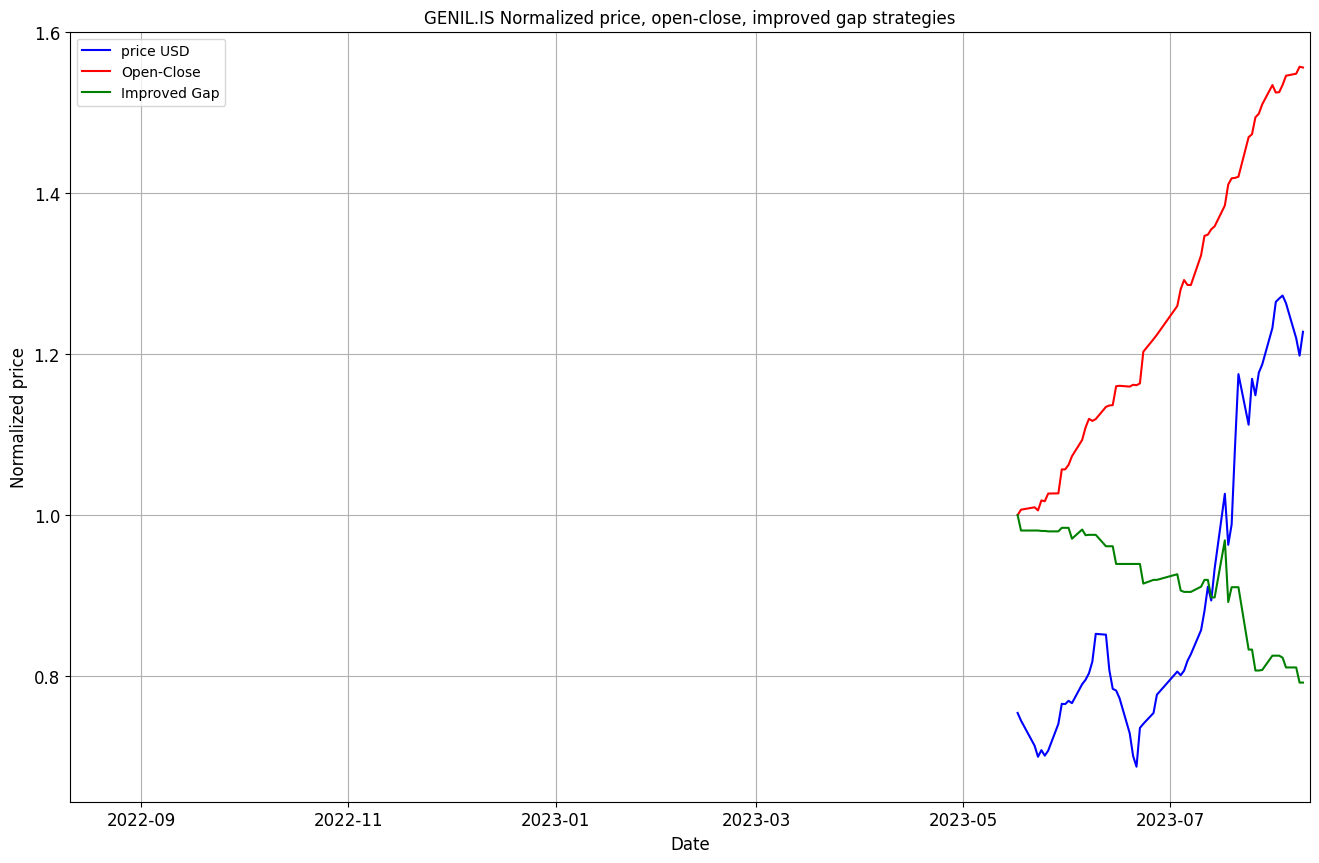


Creating Tear Sheet for GENIL.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for ULKER.IS : 



Updating data for ULKER.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for ULKER.IS

Plotting Open-Close Performance for ULKER.IS


<ipython-input-48-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


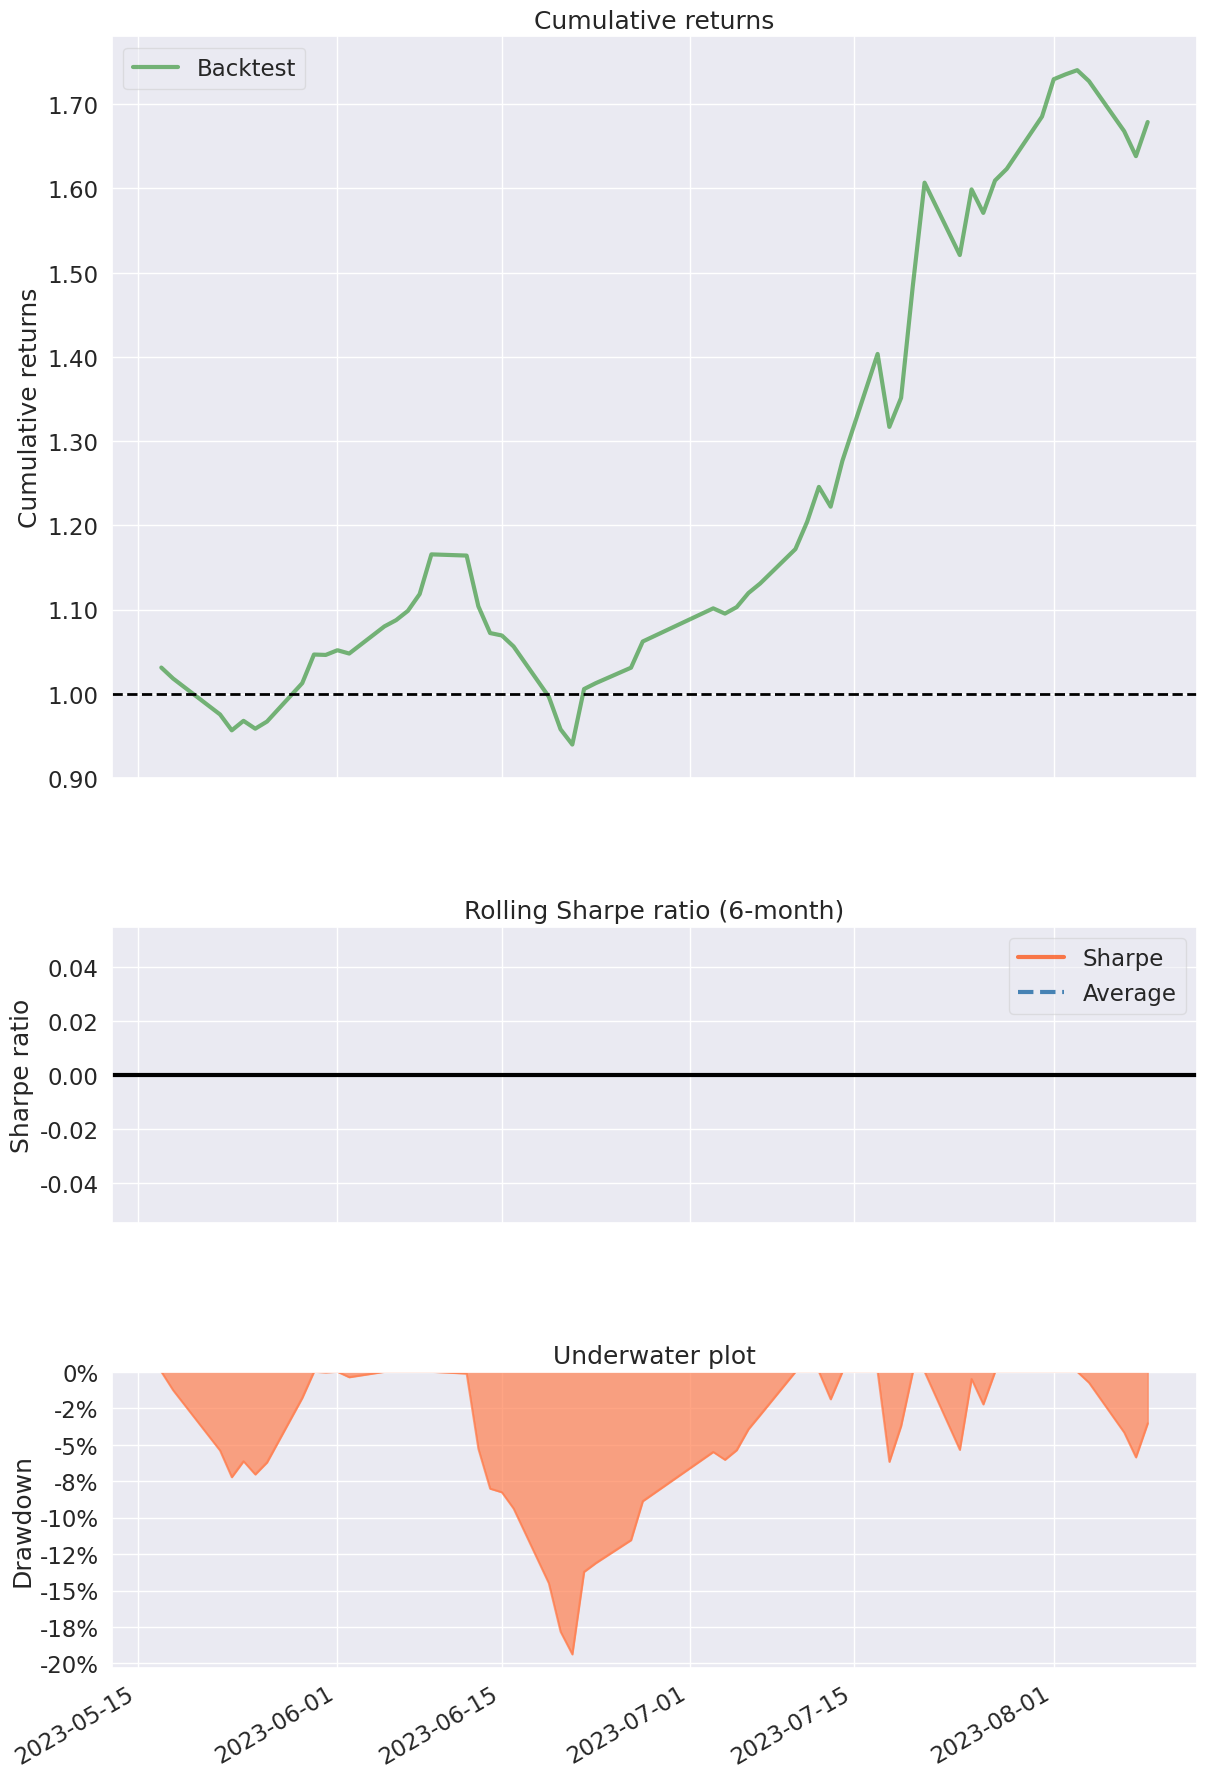

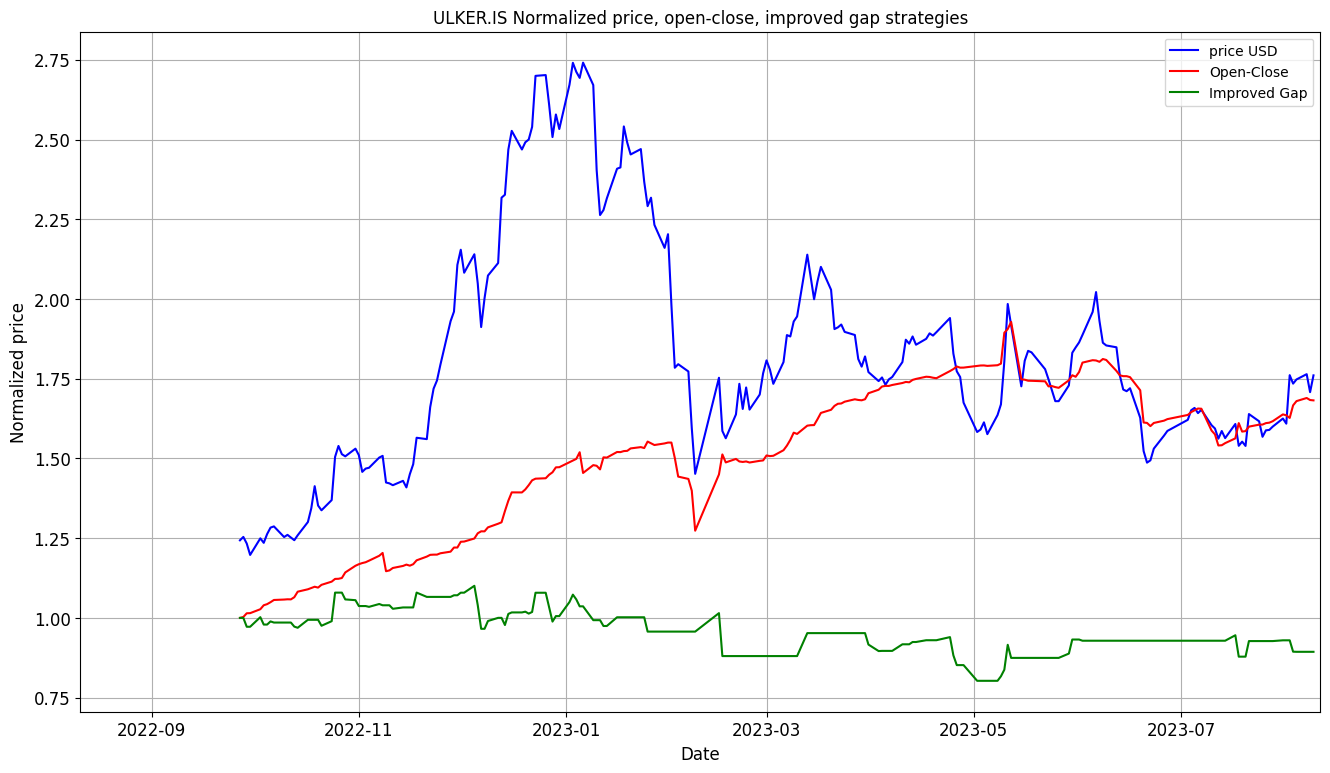


Creating Tear Sheet for ULKER.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for ECZYT.IS : 



Updating data for ECZYT.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for ECZYT.IS

Plotting Open-Close Performance for ECZYT.IS


<ipython-input-48-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


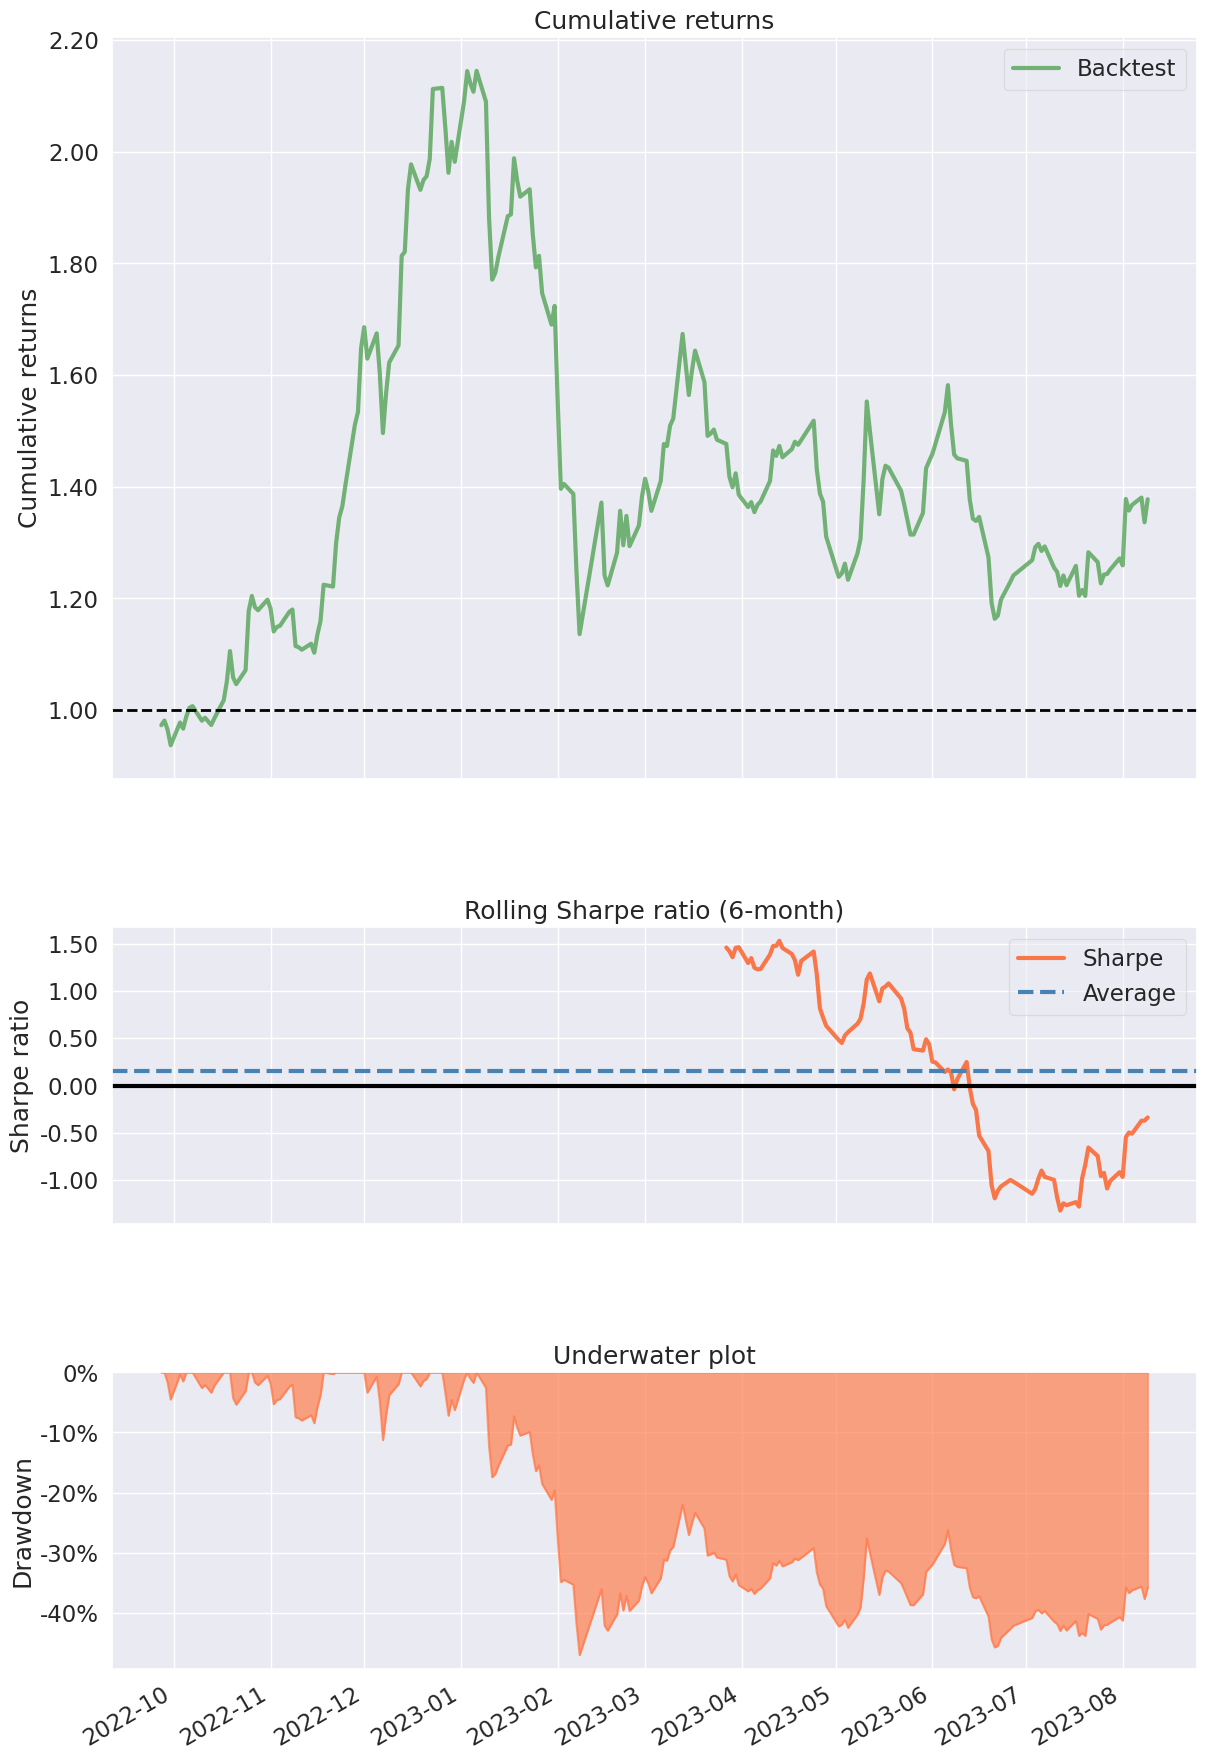

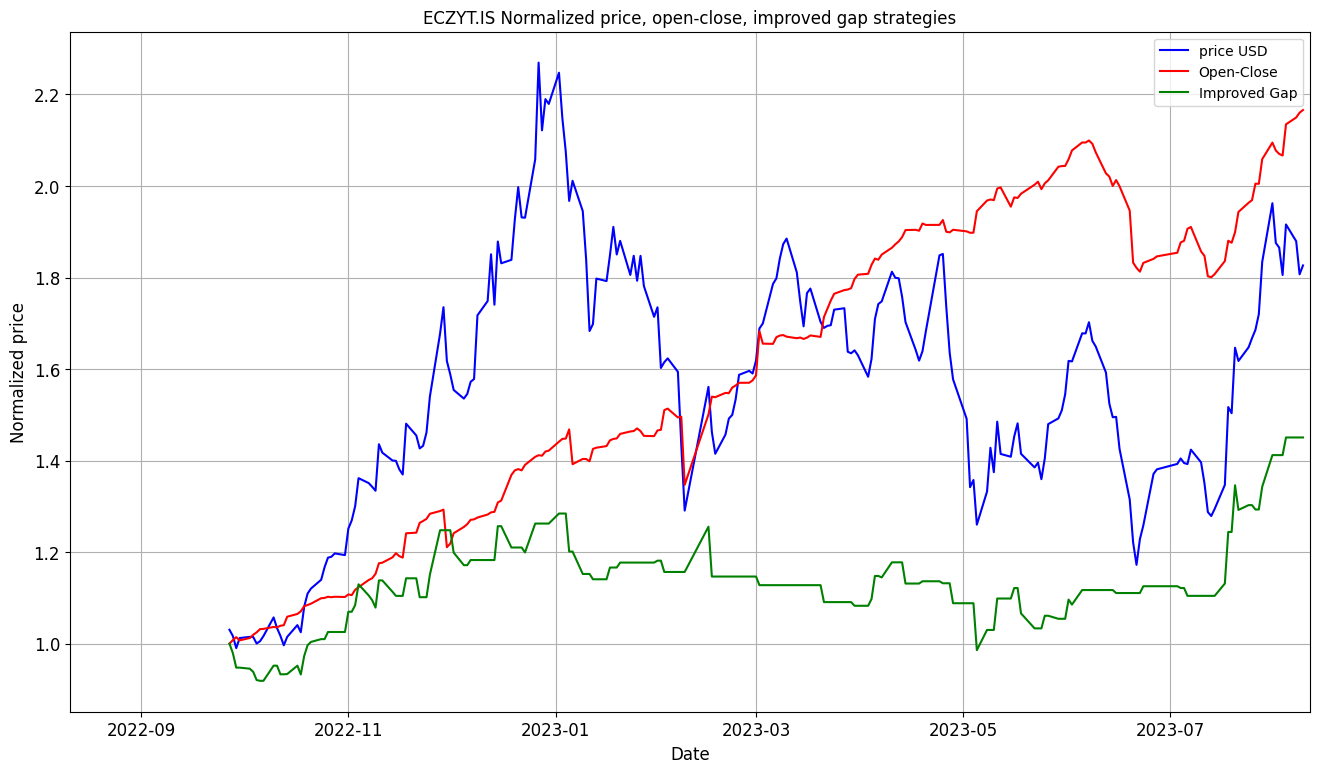


Creating Tear Sheet for ECZYT.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for VESBE.IS : 



Updating data for VESBE.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for VESBE.IS

Plotting Open-Close Performance for VESBE.IS


<ipython-input-48-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


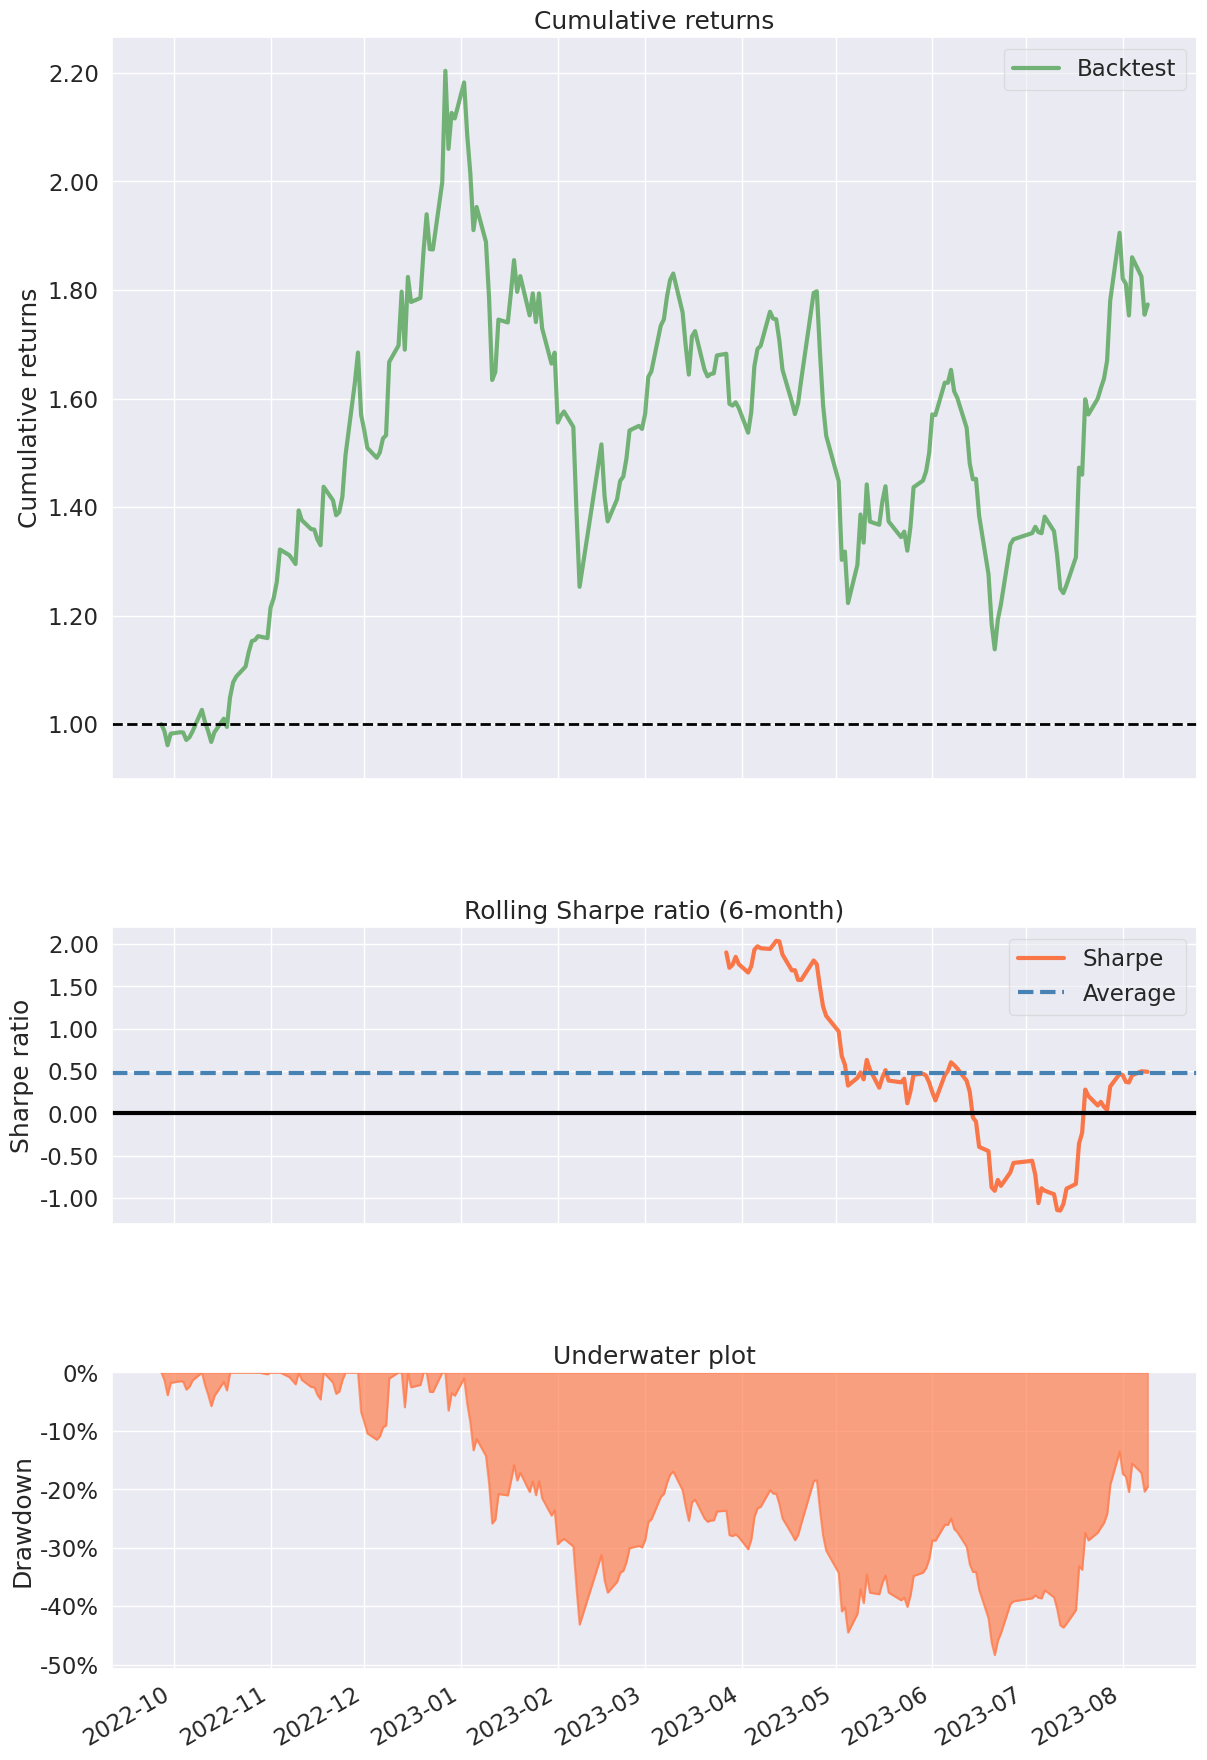

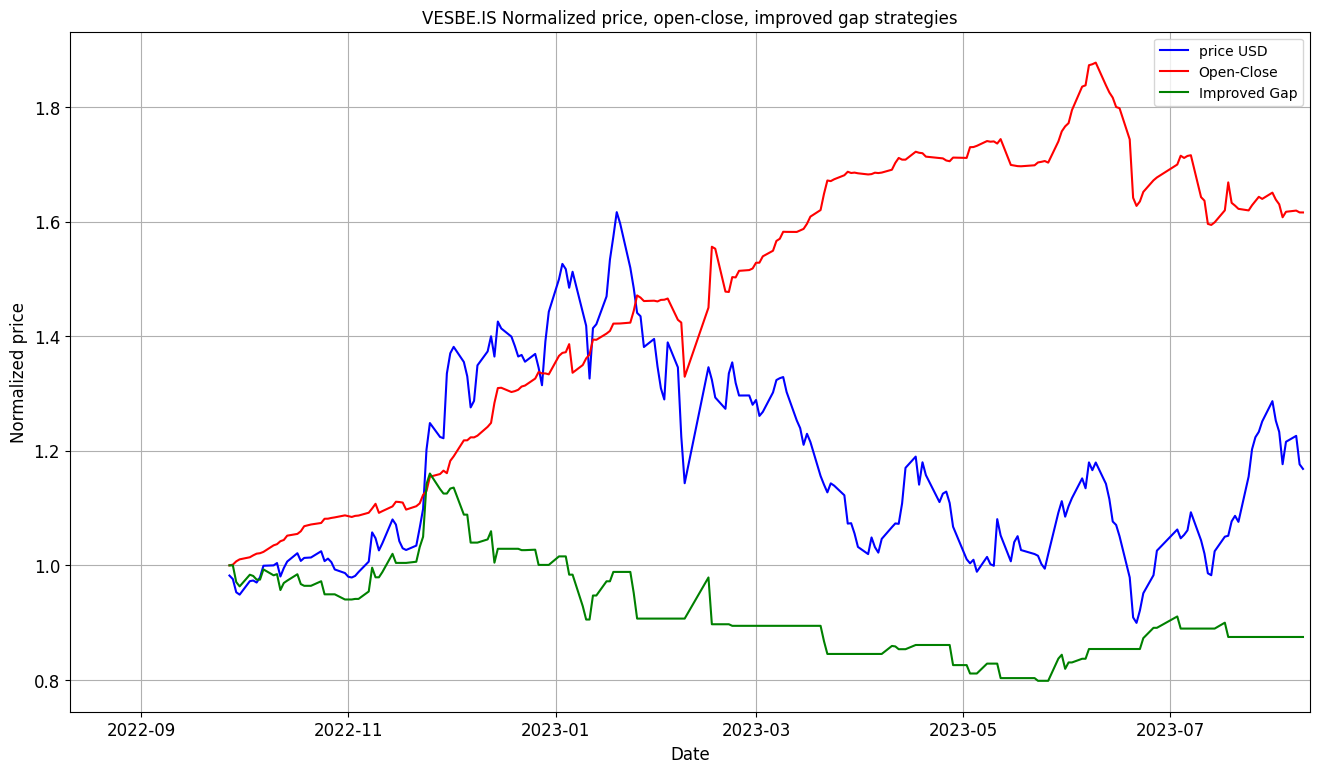


Creating Tear Sheet for VESBE.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for ENKAI.IS : 



Updating data for ENKAI.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for ENKAI.IS

Plotting Open-Close Performance for ENKAI.IS


<ipython-input-48-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


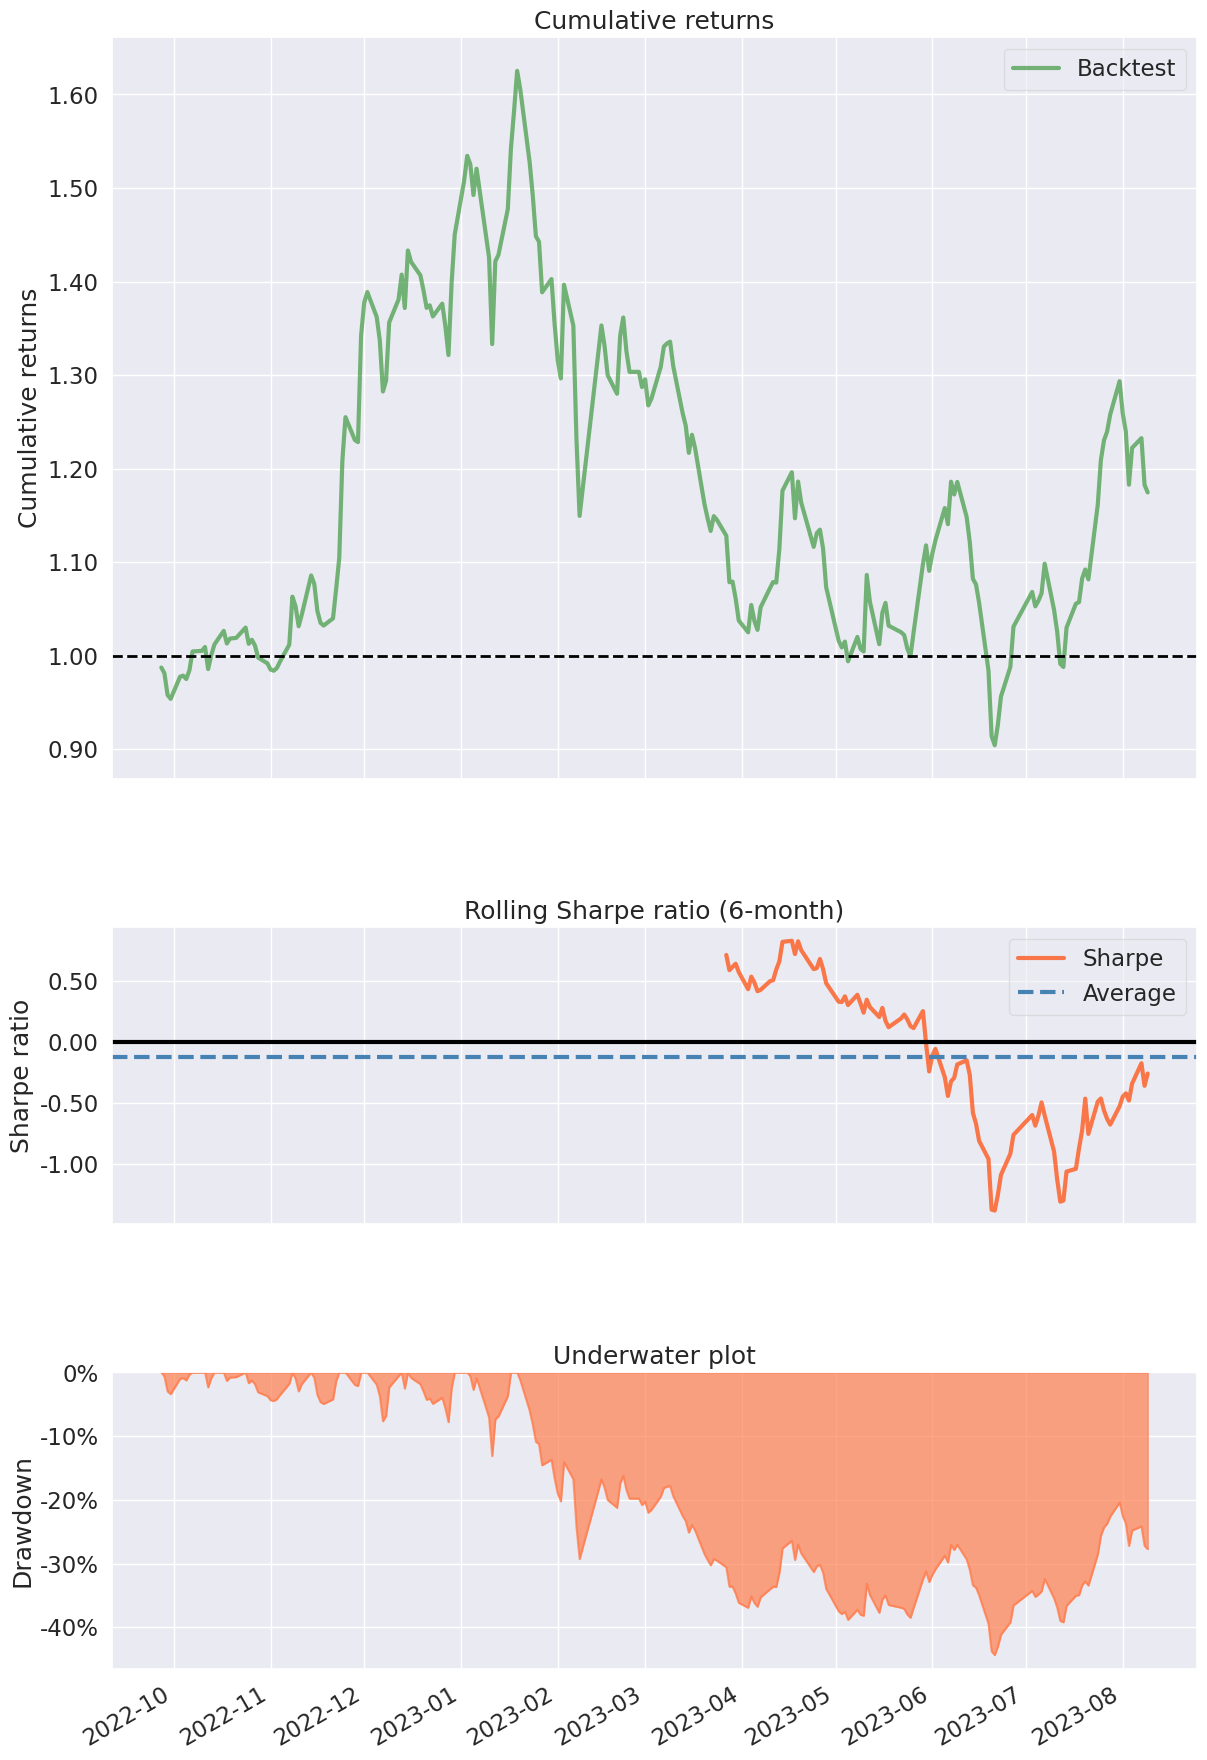

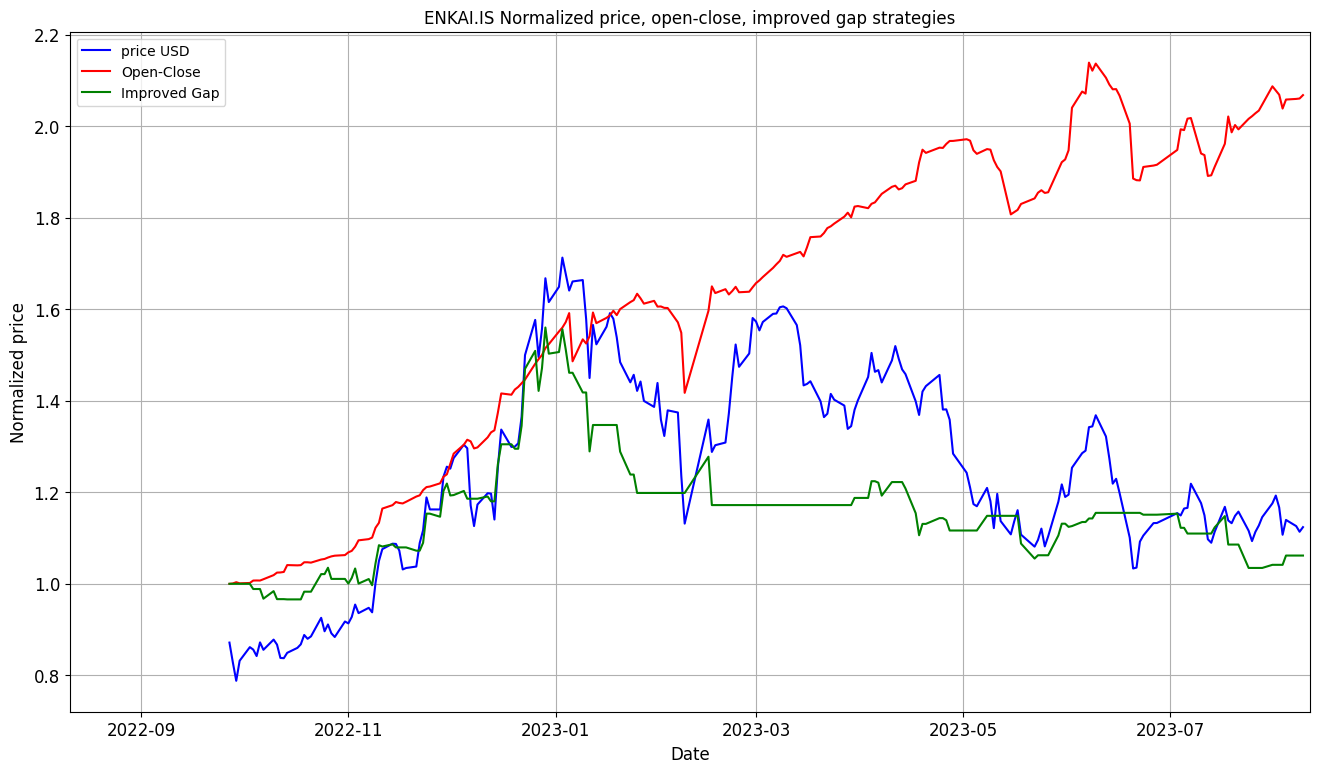


Creating Tear Sheet for ENKAI.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for BUCIM.IS : 



Updating data for BUCIM.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for BUCIM.IS

Plotting Open-Close Performance for BUCIM.IS


<ipython-input-48-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


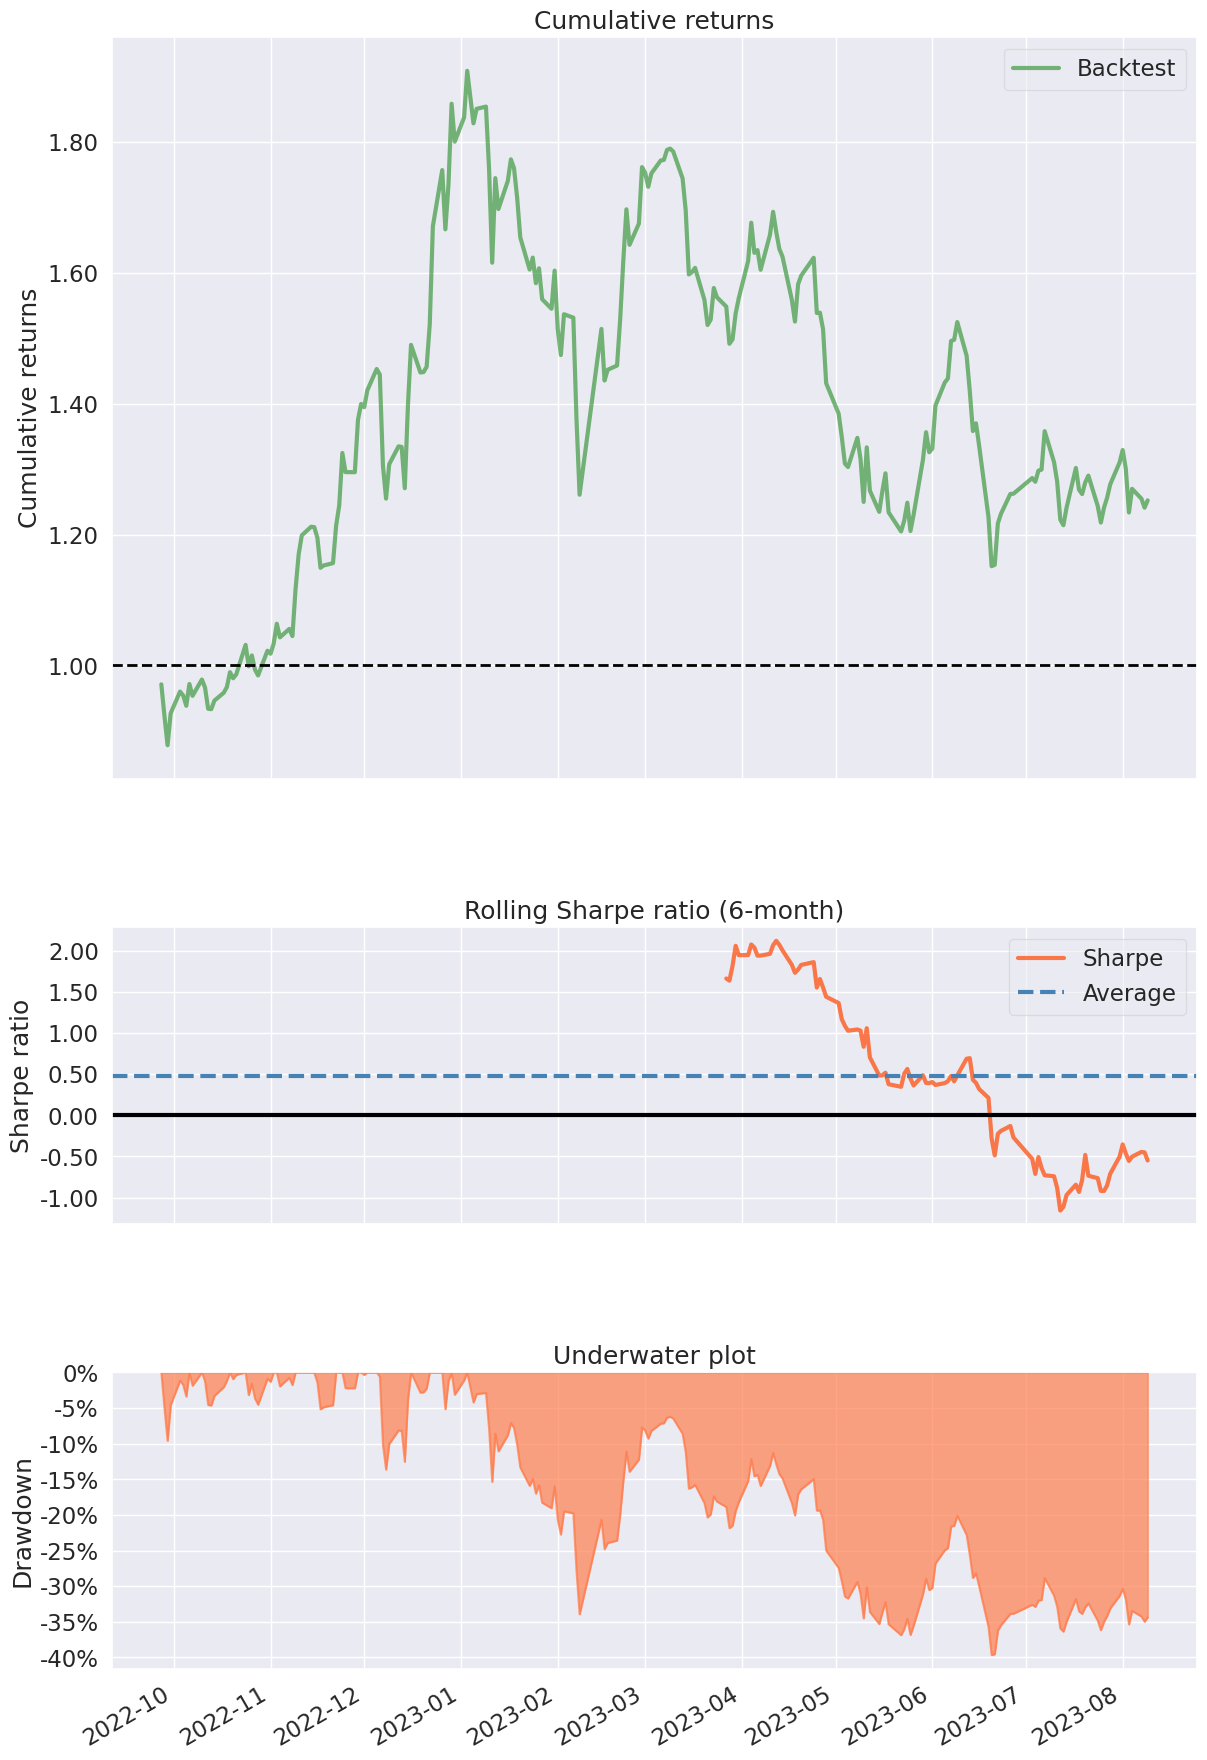

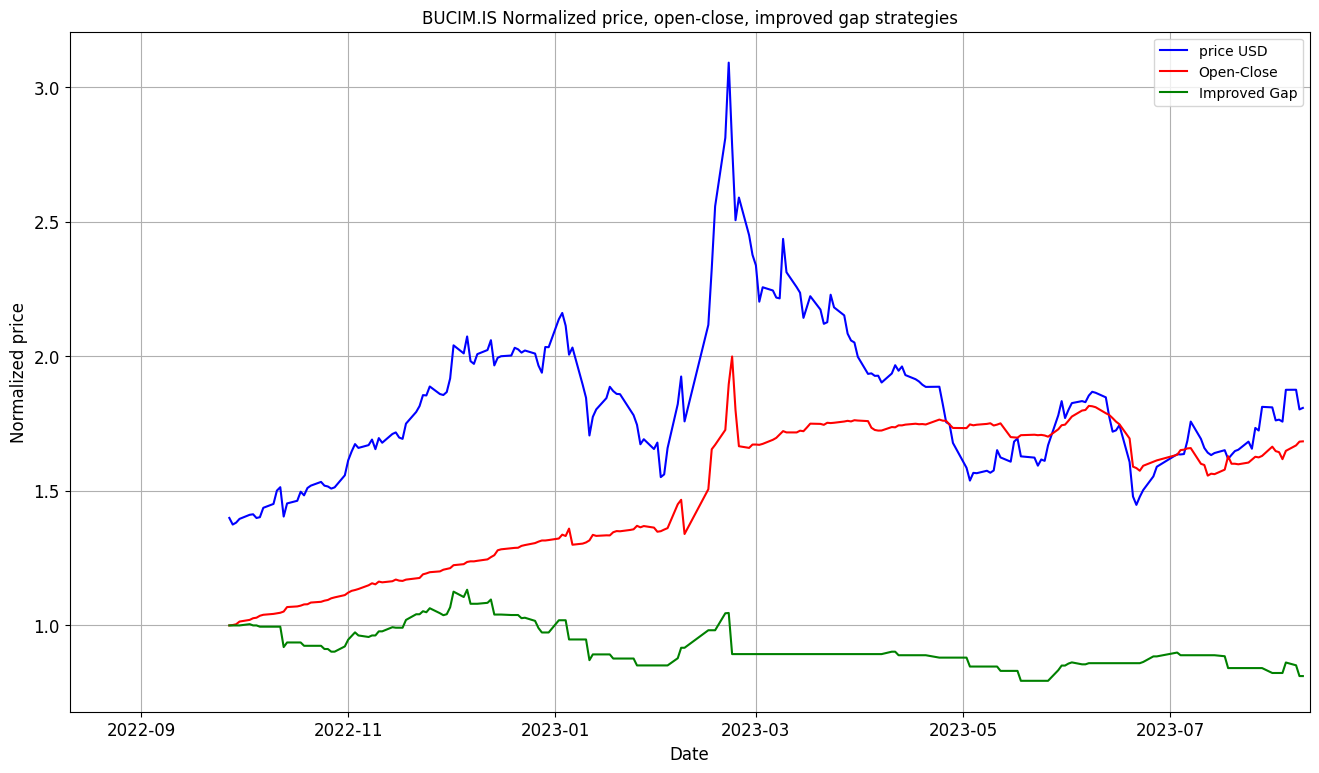


Creating Tear Sheet for BUCIM.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for ODAS.IS : 



Updating data for ODAS.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for ODAS.IS

Plotting Open-Close Performance for ODAS.IS


<ipython-input-48-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


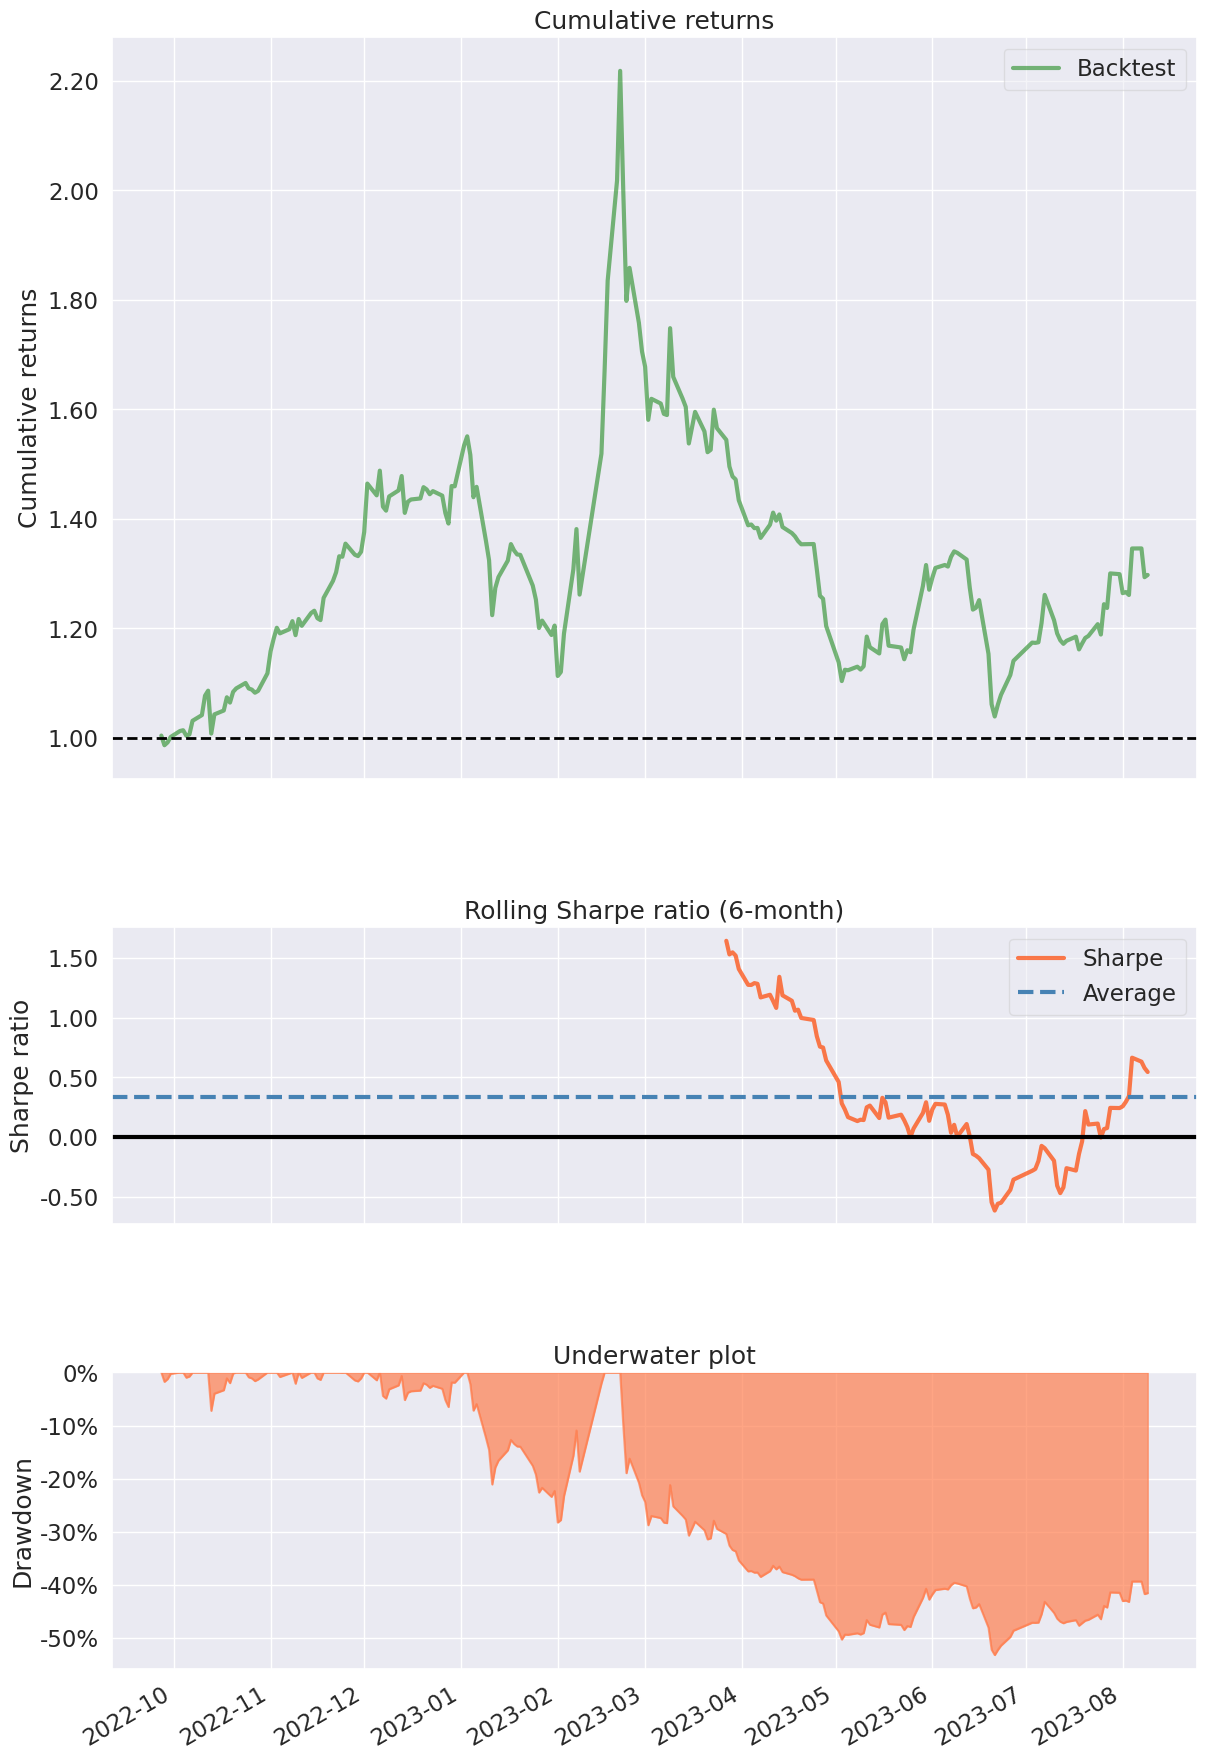

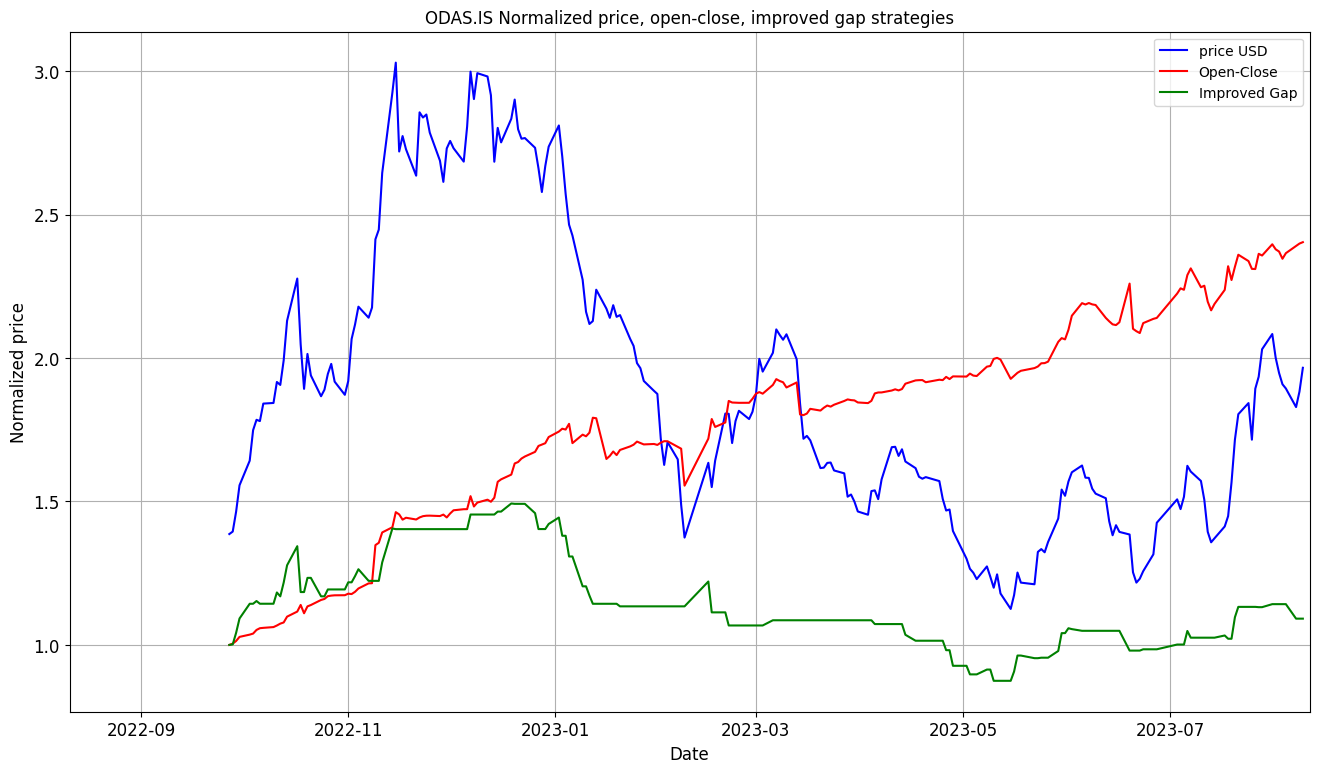


Creating Tear Sheet for ODAS.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for GSDHO.IS : 



Updating data for GSDHO.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for GSDHO.IS

Plotting Open-Close Performance for GSDHO.IS


<ipython-input-48-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


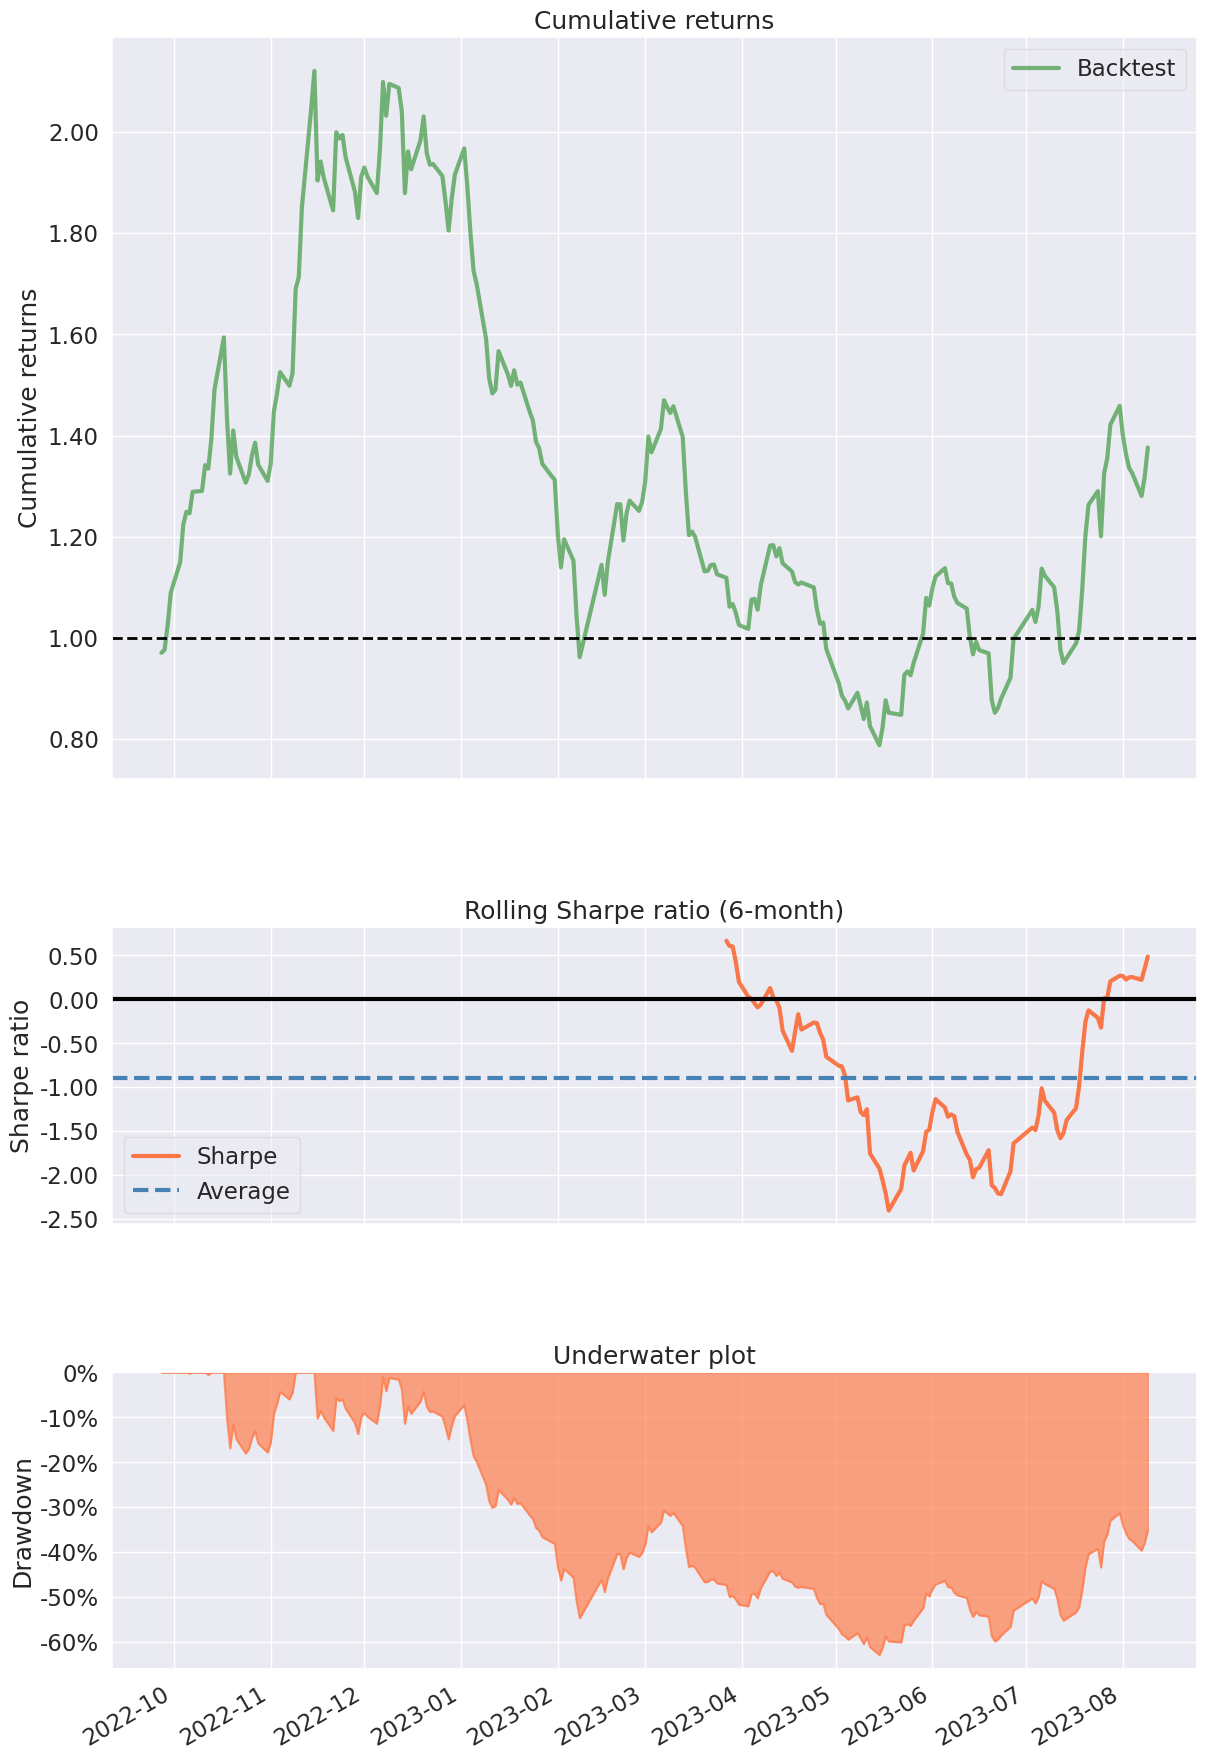

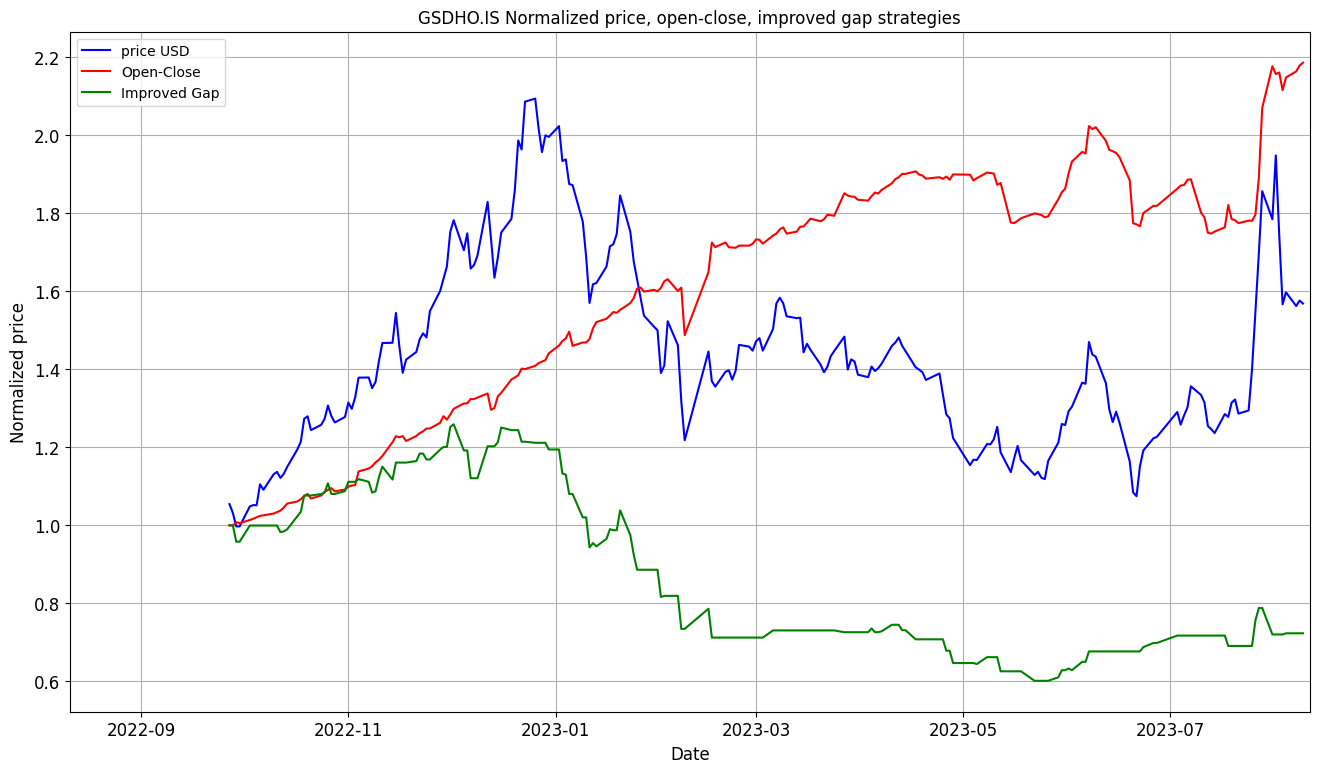


Creating Tear Sheet for GSDHO.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for SNGYO.IS : 



Updating data for SNGYO.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for SNGYO.IS

Plotting Open-Close Performance for SNGYO.IS


<ipython-input-48-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


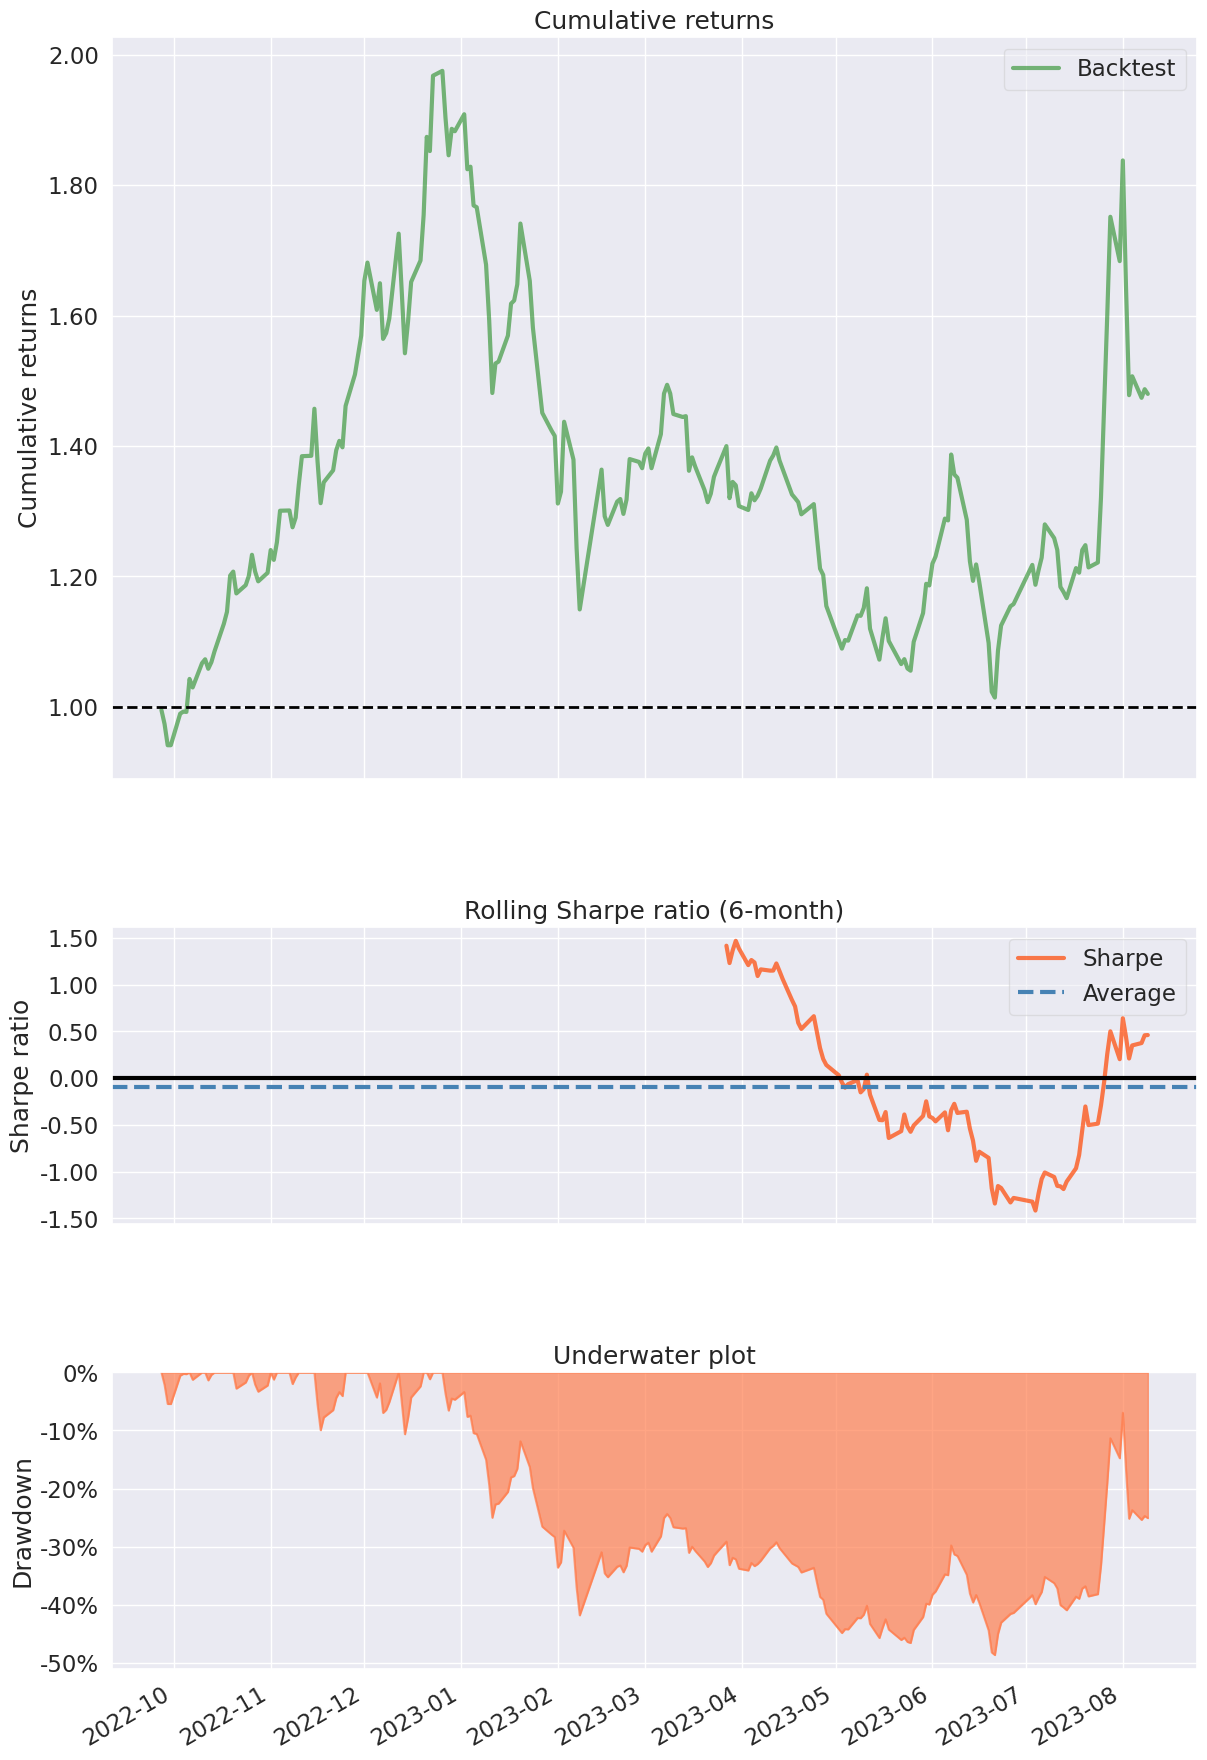

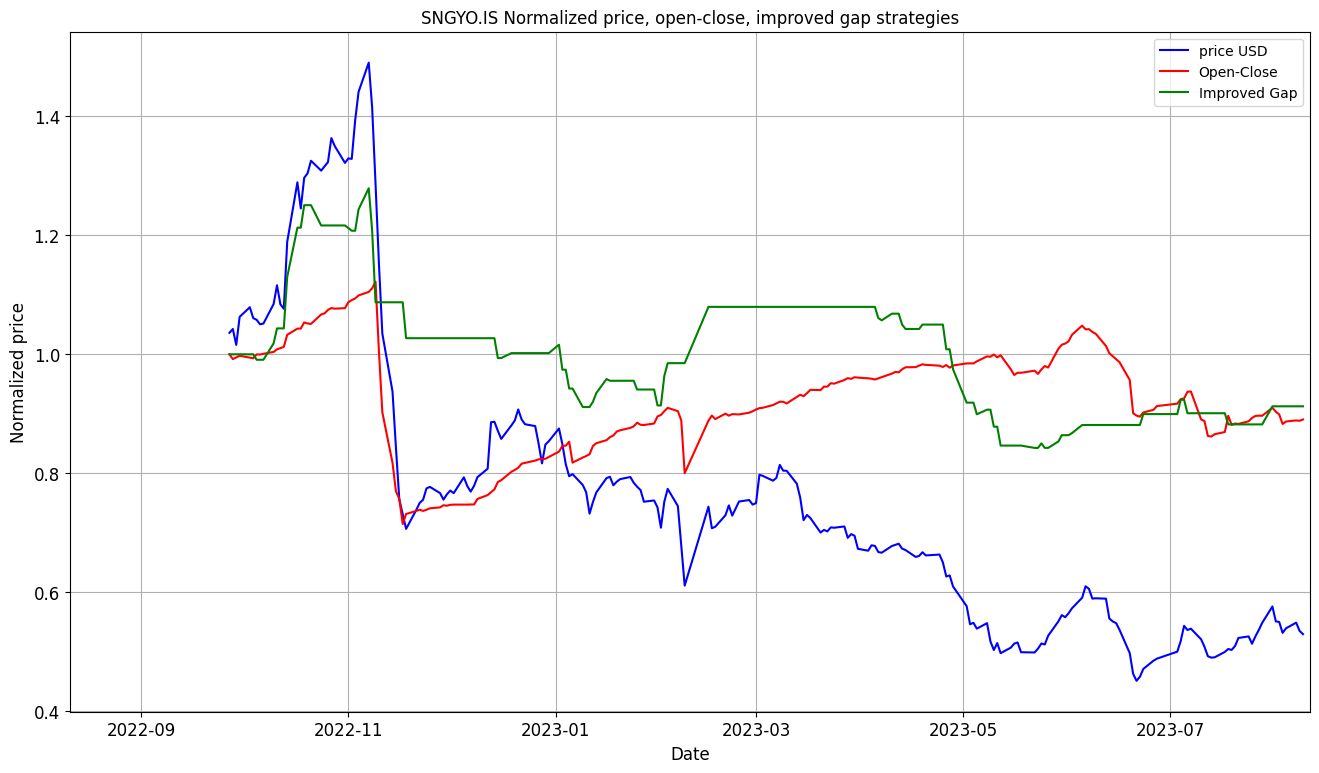


Creating Tear Sheet for SNGYO.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for KONYA.IS : 



Updating data for KONYA.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for KONYA.IS

Plotting Open-Close Performance for KONYA.IS


<ipython-input-48-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


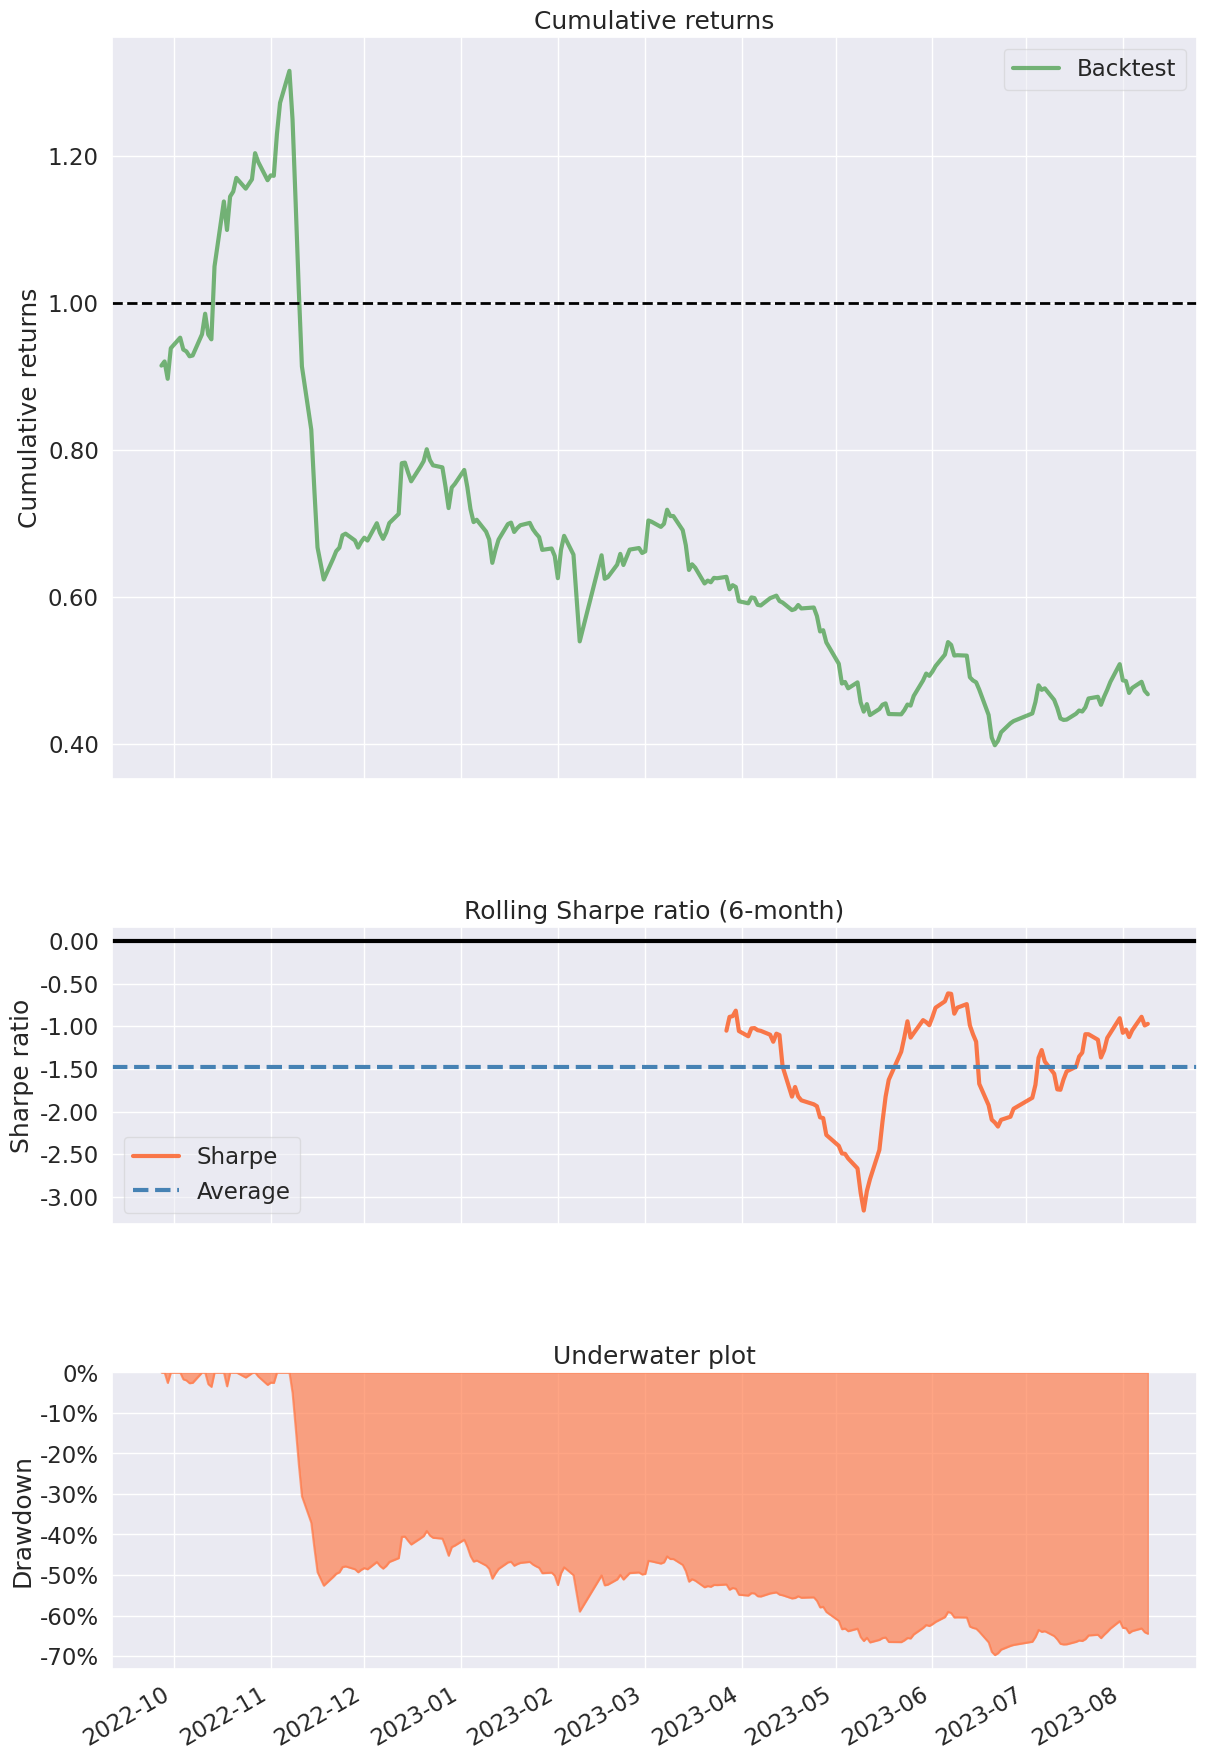

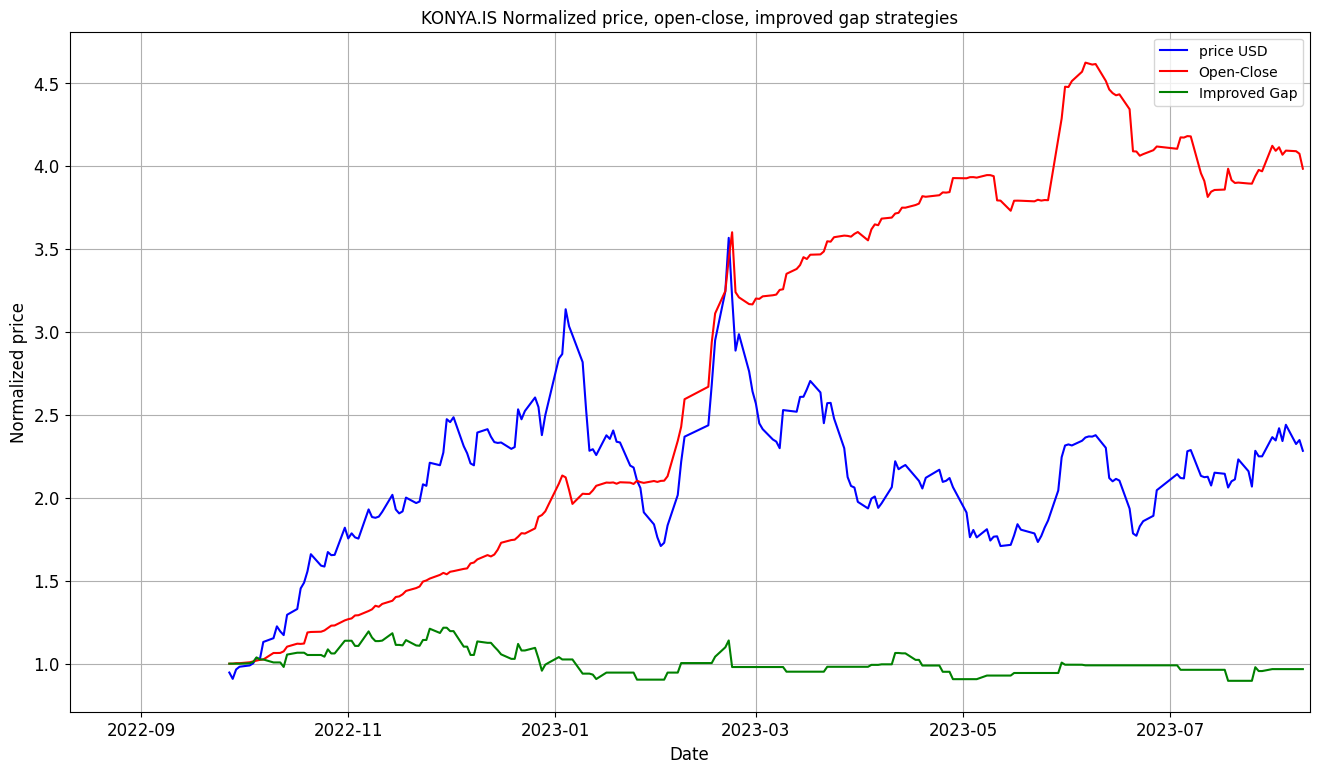


Creating Tear Sheet for KONYA.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for AGHOL.IS : 



Updating data for AGHOL.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for AGHOL.IS

Plotting Open-Close Performance for AGHOL.IS


<ipython-input-48-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


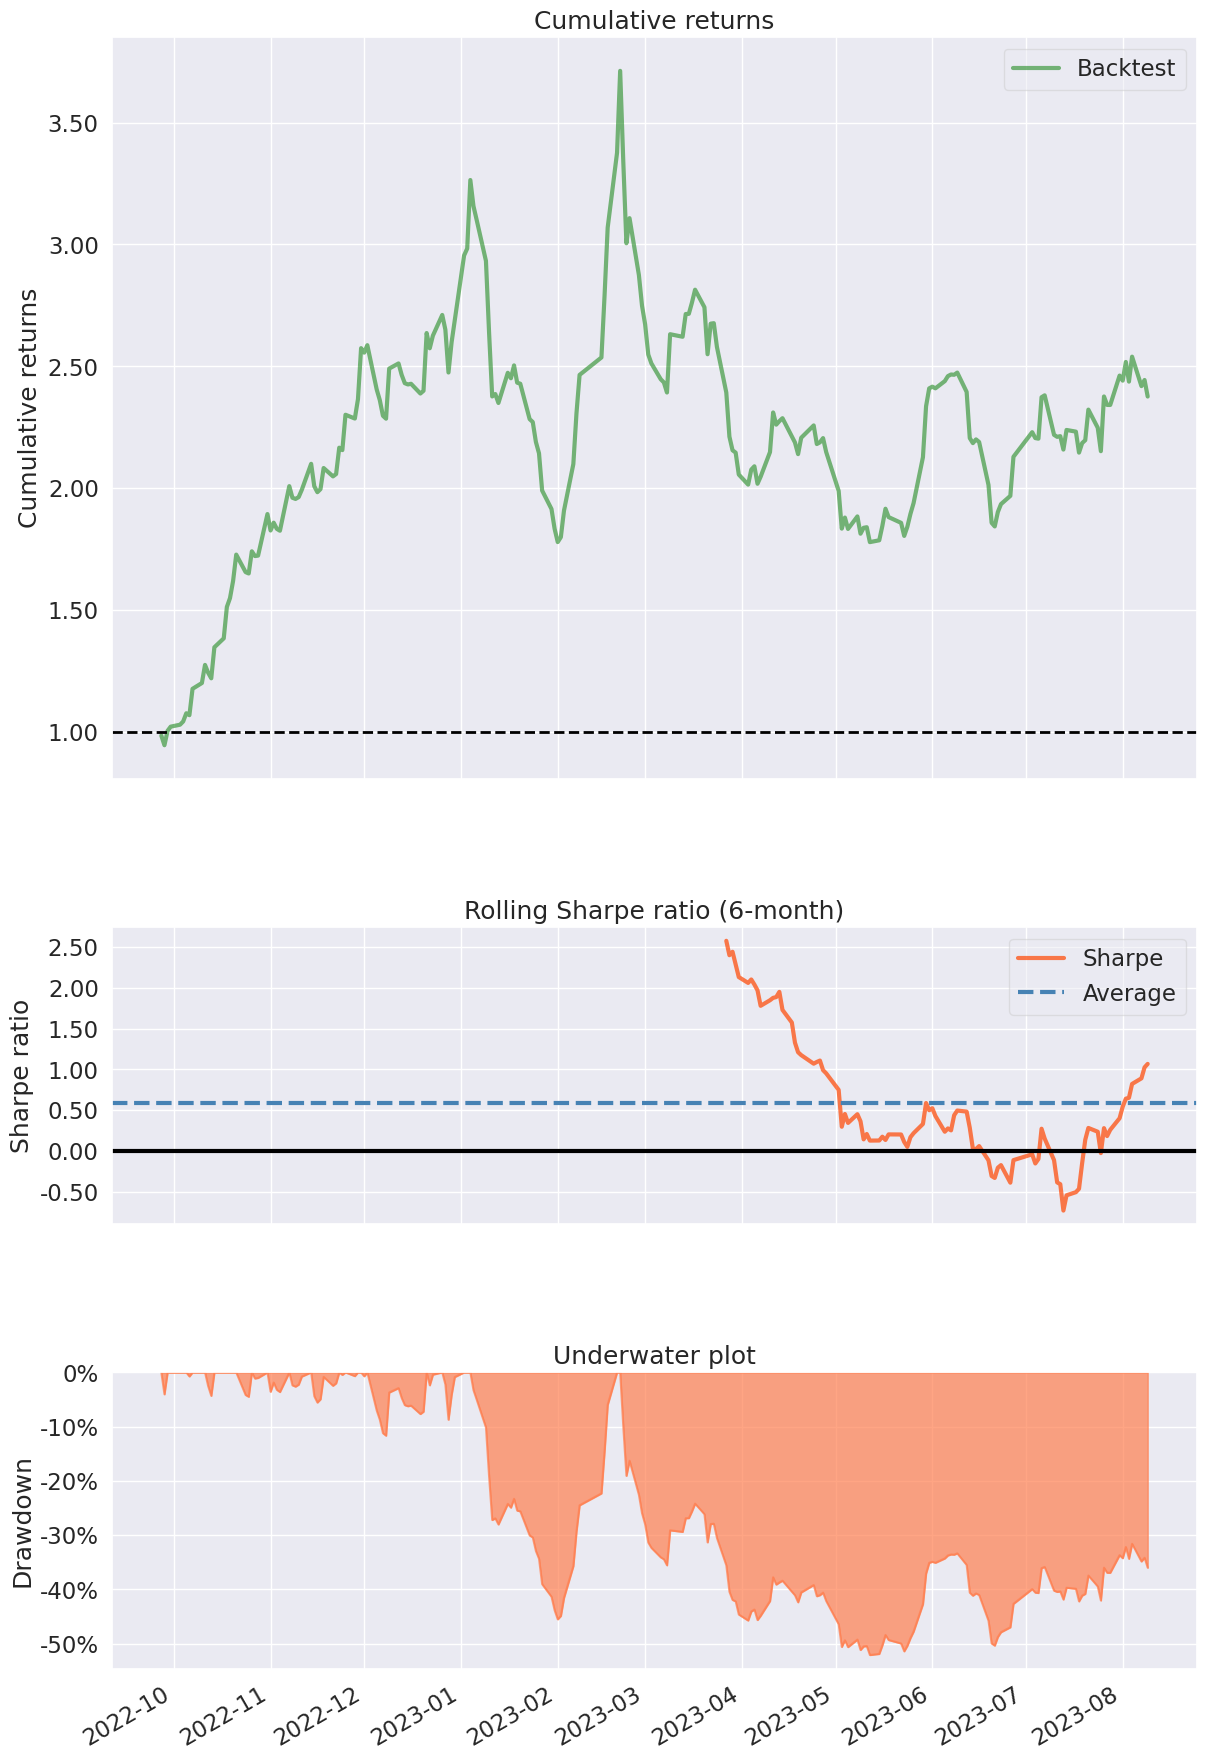

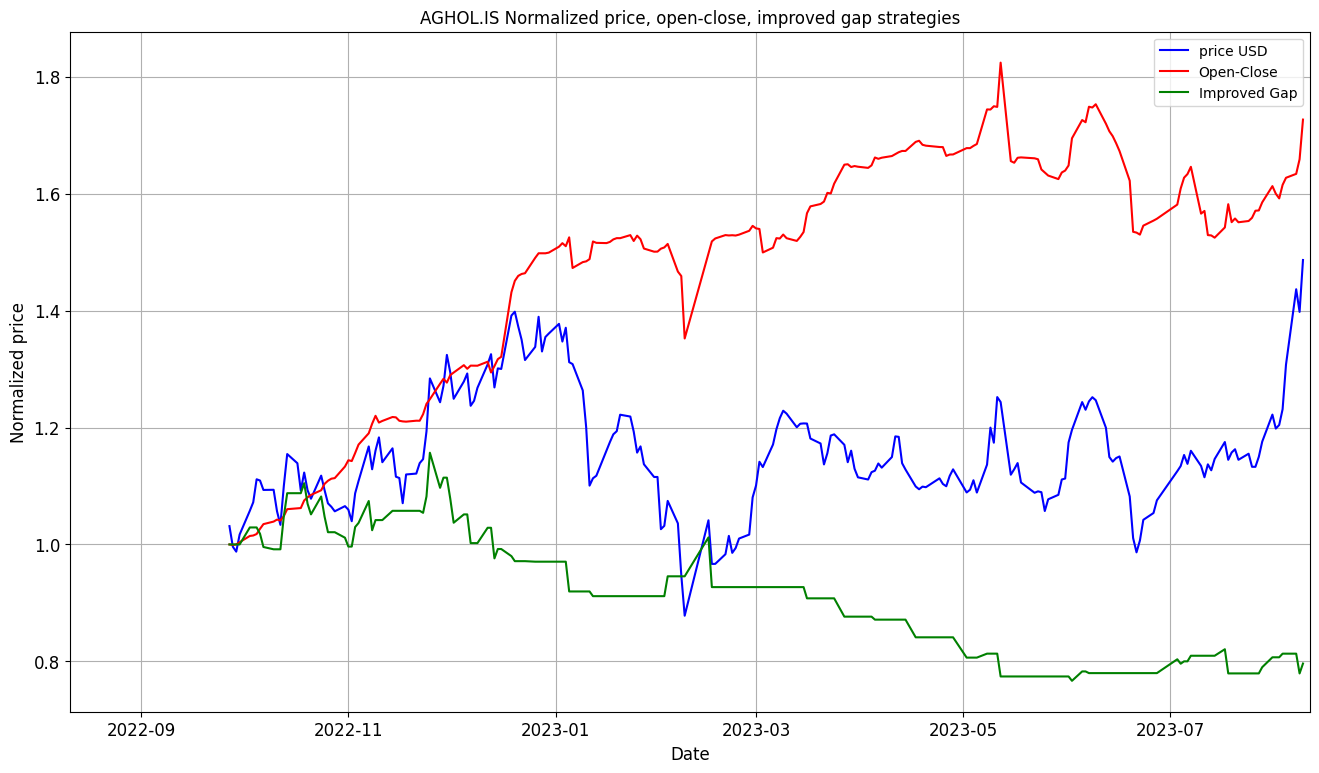


Creating Tear Sheet for AGHOL.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for ISGYO.IS : 



Updating data for ISGYO.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for ISGYO.IS

Plotting Open-Close Performance for ISGYO.IS


<ipython-input-48-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


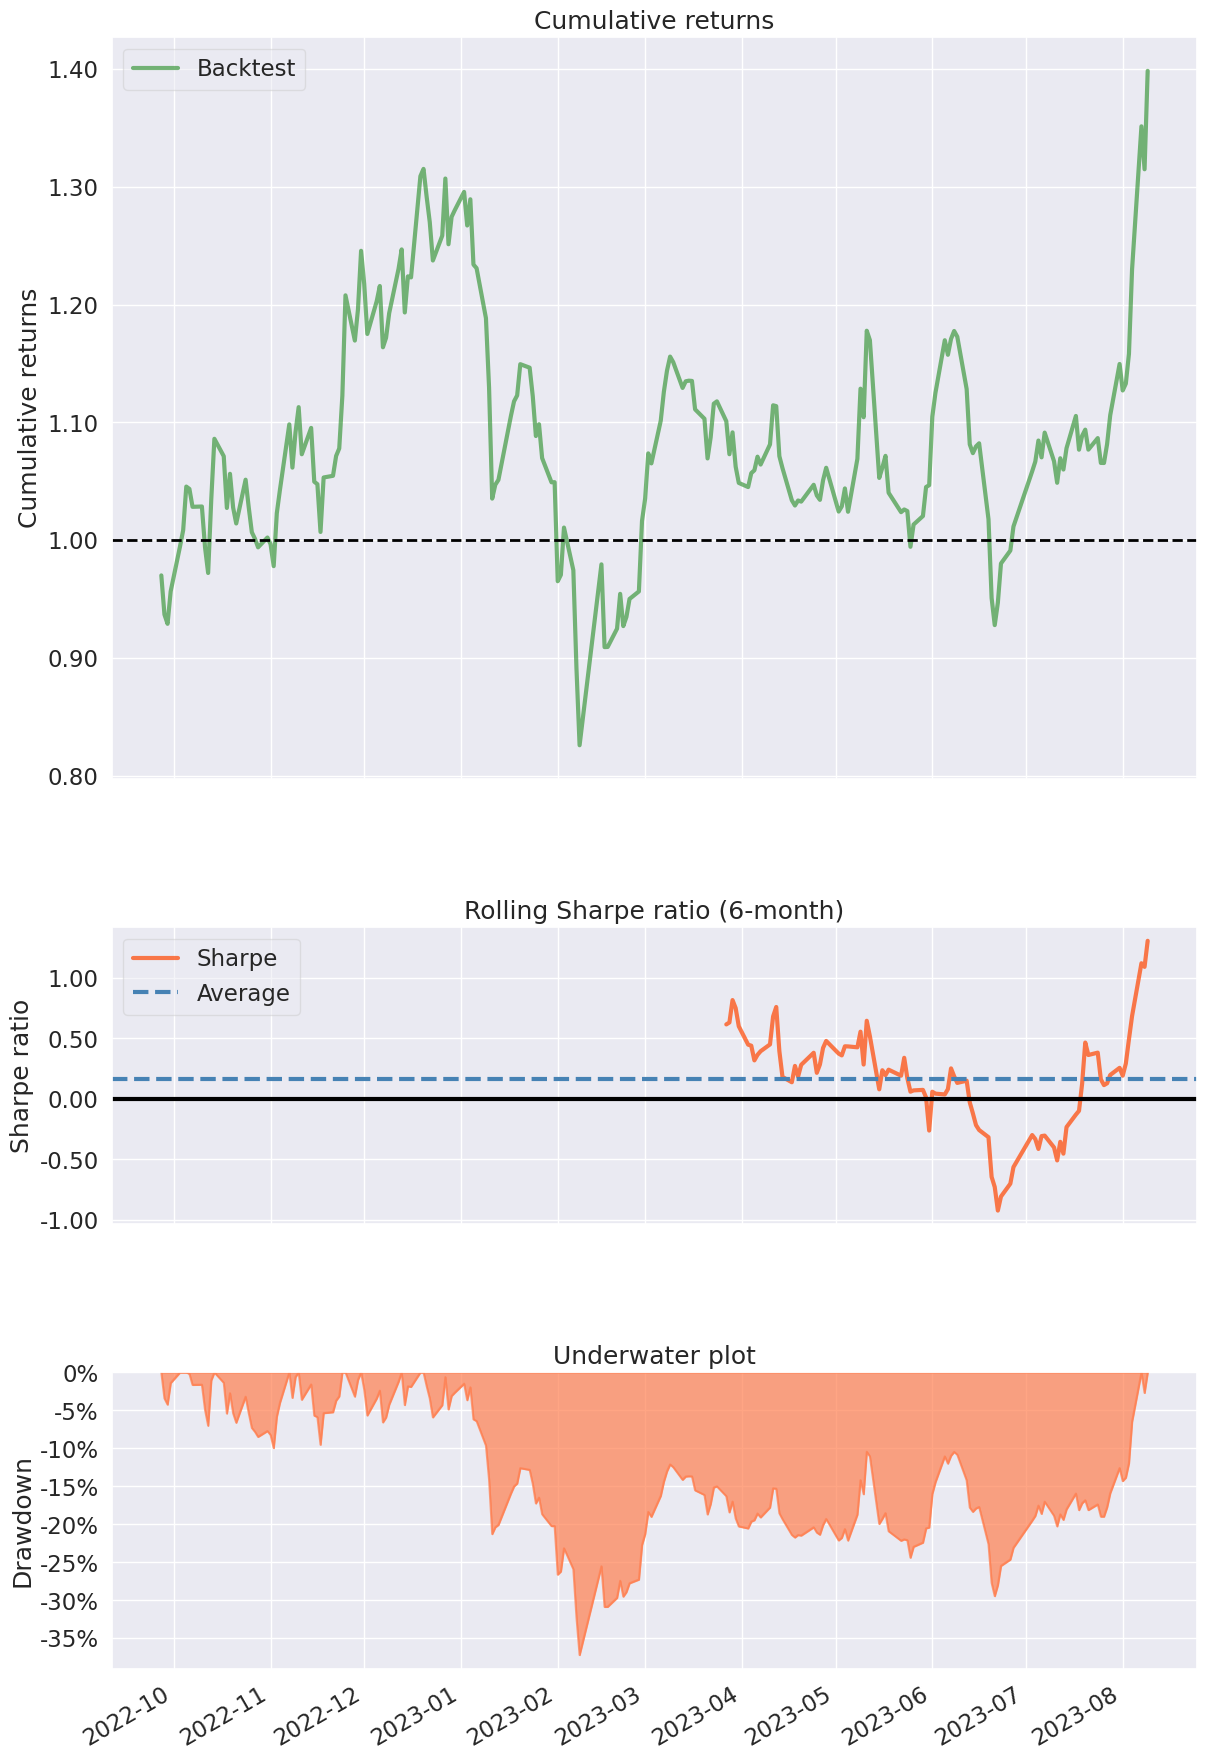

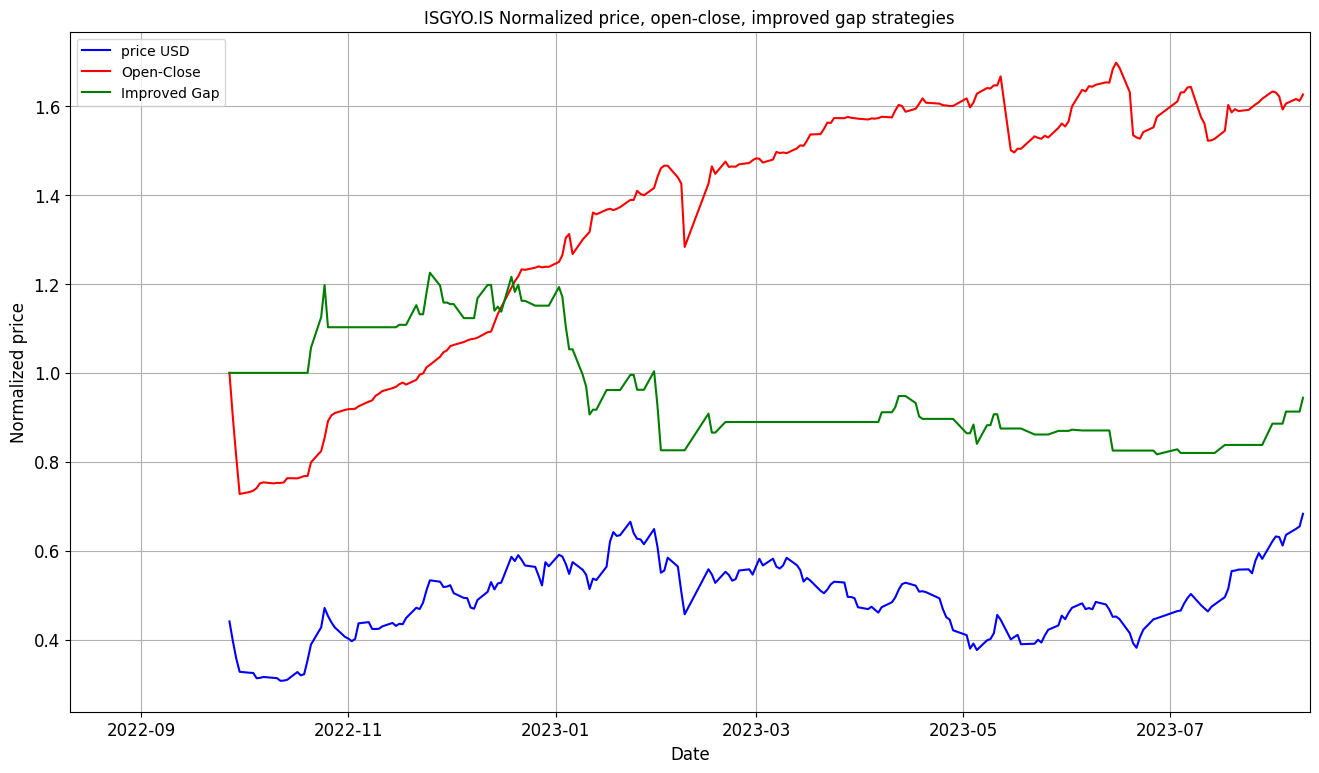


Creating Tear Sheet for ISGYO.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for BIMAS.IS : 



Updating data for BIMAS.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for BIMAS.IS

Plotting Open-Close Performance for BIMAS.IS


<ipython-input-48-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


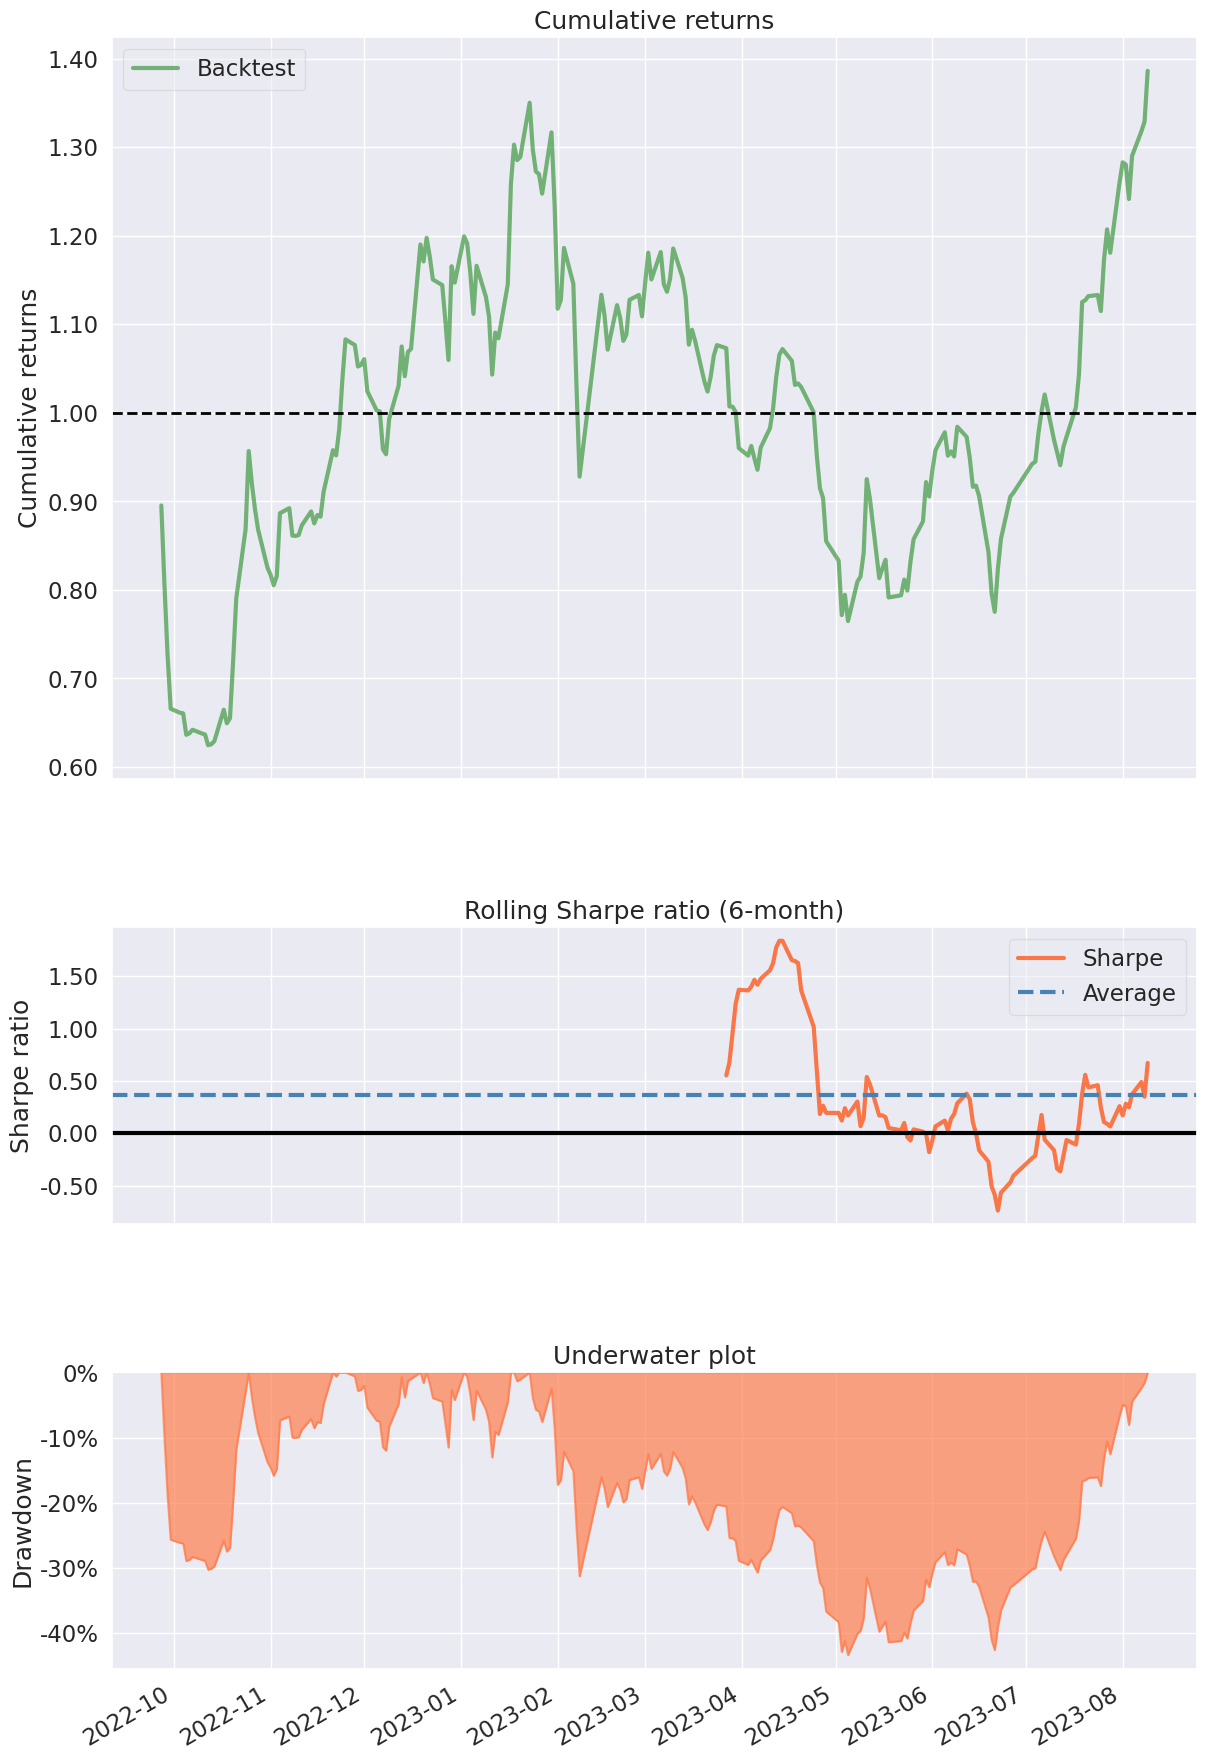

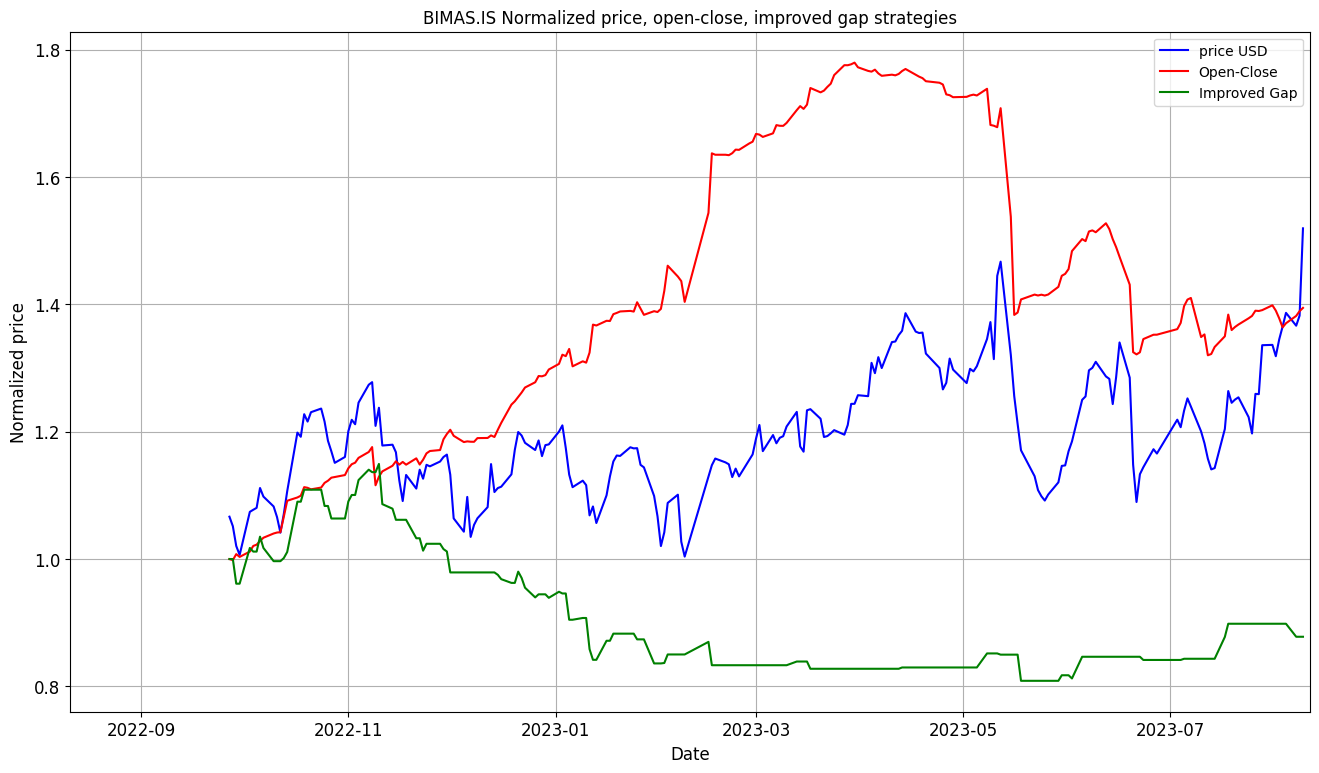


Creating Tear Sheet for BIMAS.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for ECILC.IS : 



Updating data for ECILC.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for ECILC.IS

Plotting Open-Close Performance for ECILC.IS


<ipython-input-48-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


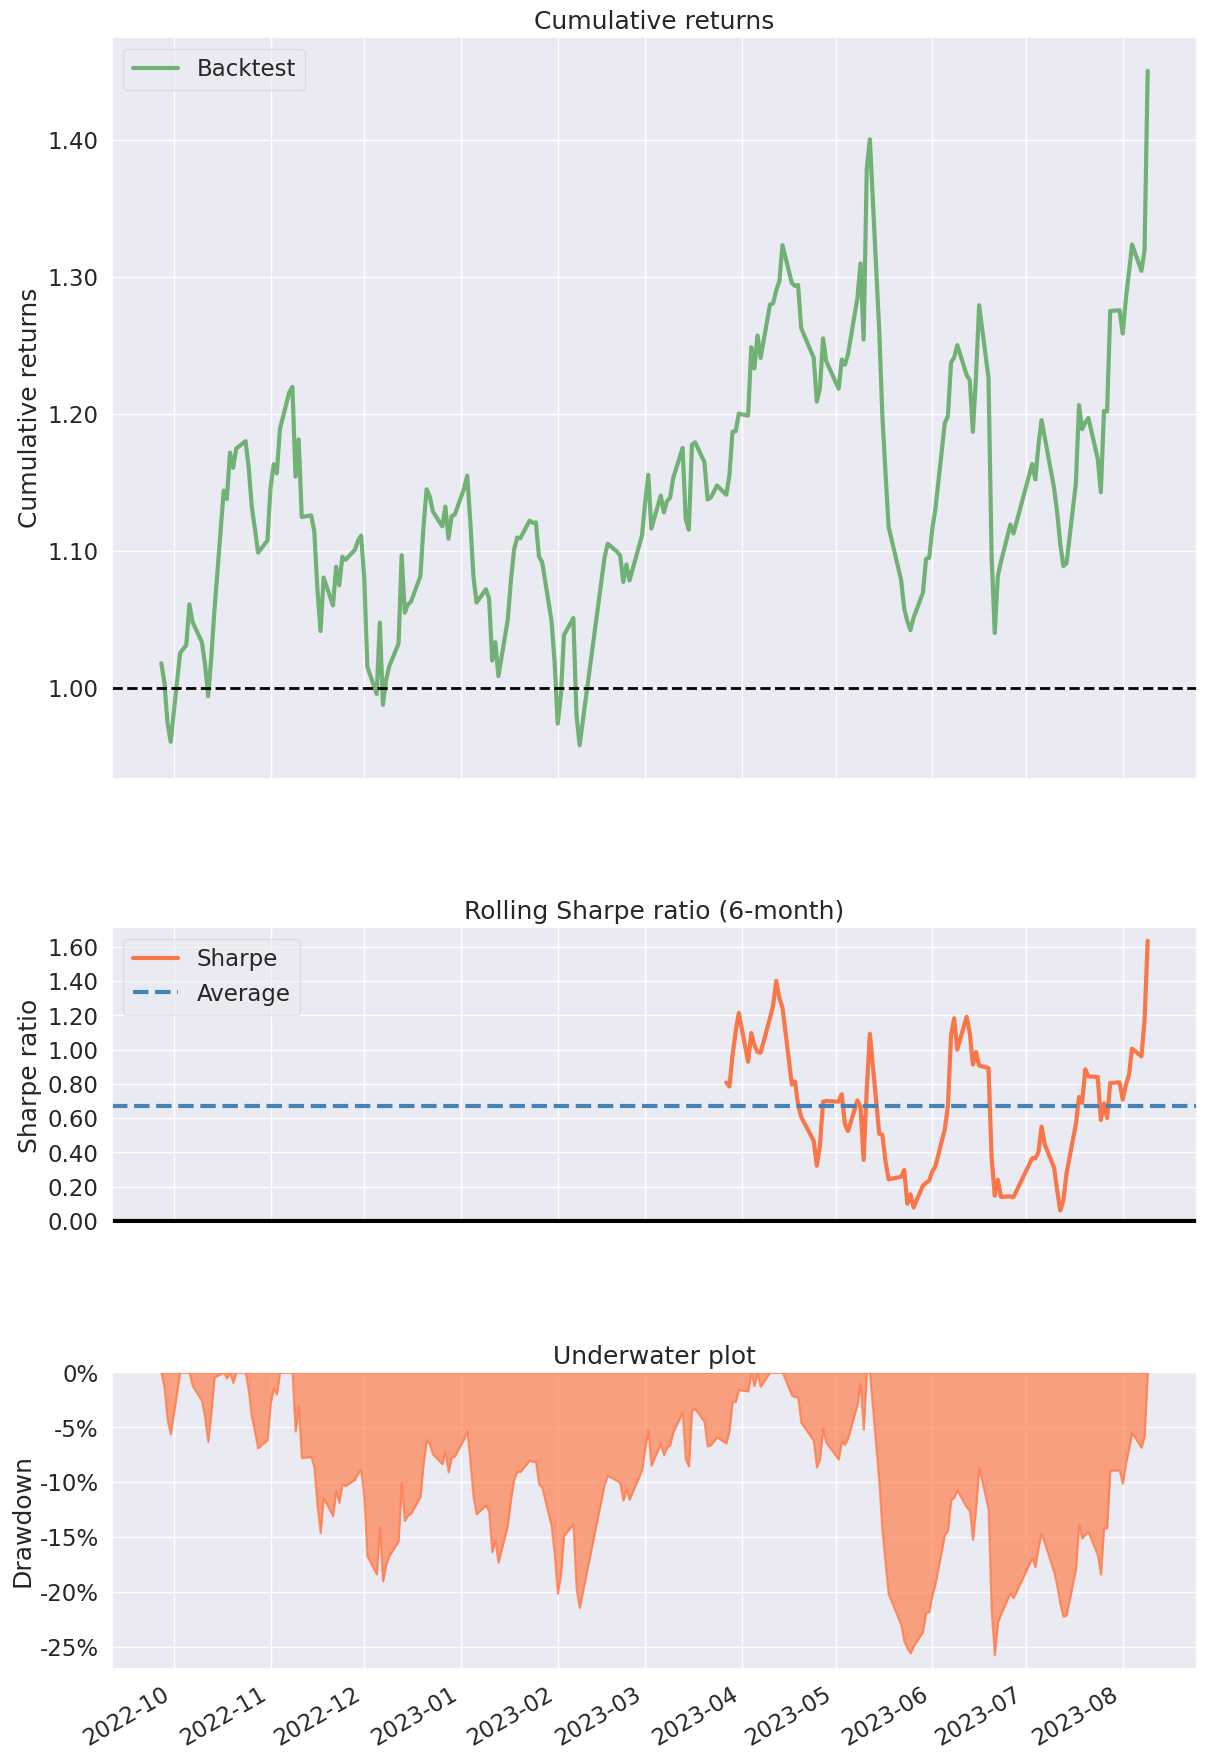

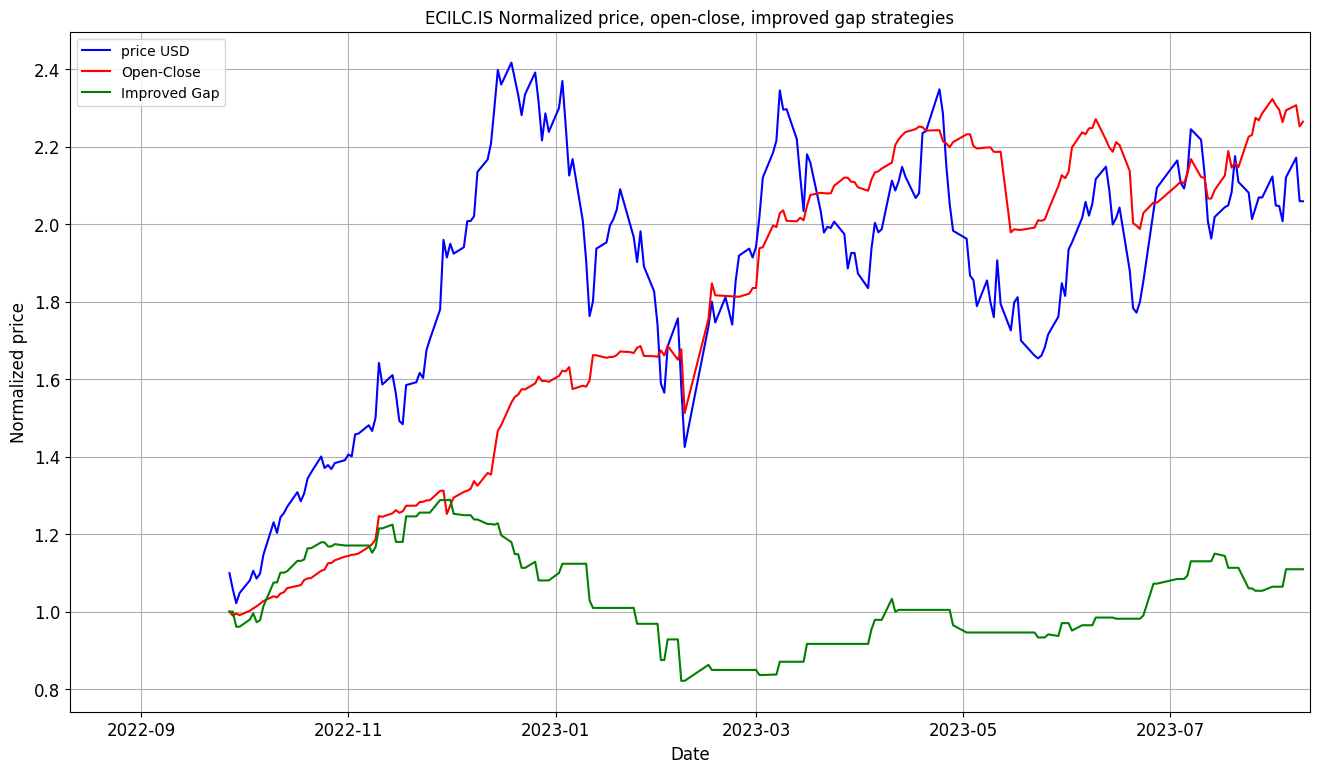


Creating Tear Sheet for ECILC.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for ALARK.IS : 



Updating data for ALARK.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for ALARK.IS

Plotting Open-Close Performance for ALARK.IS


<ipython-input-48-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


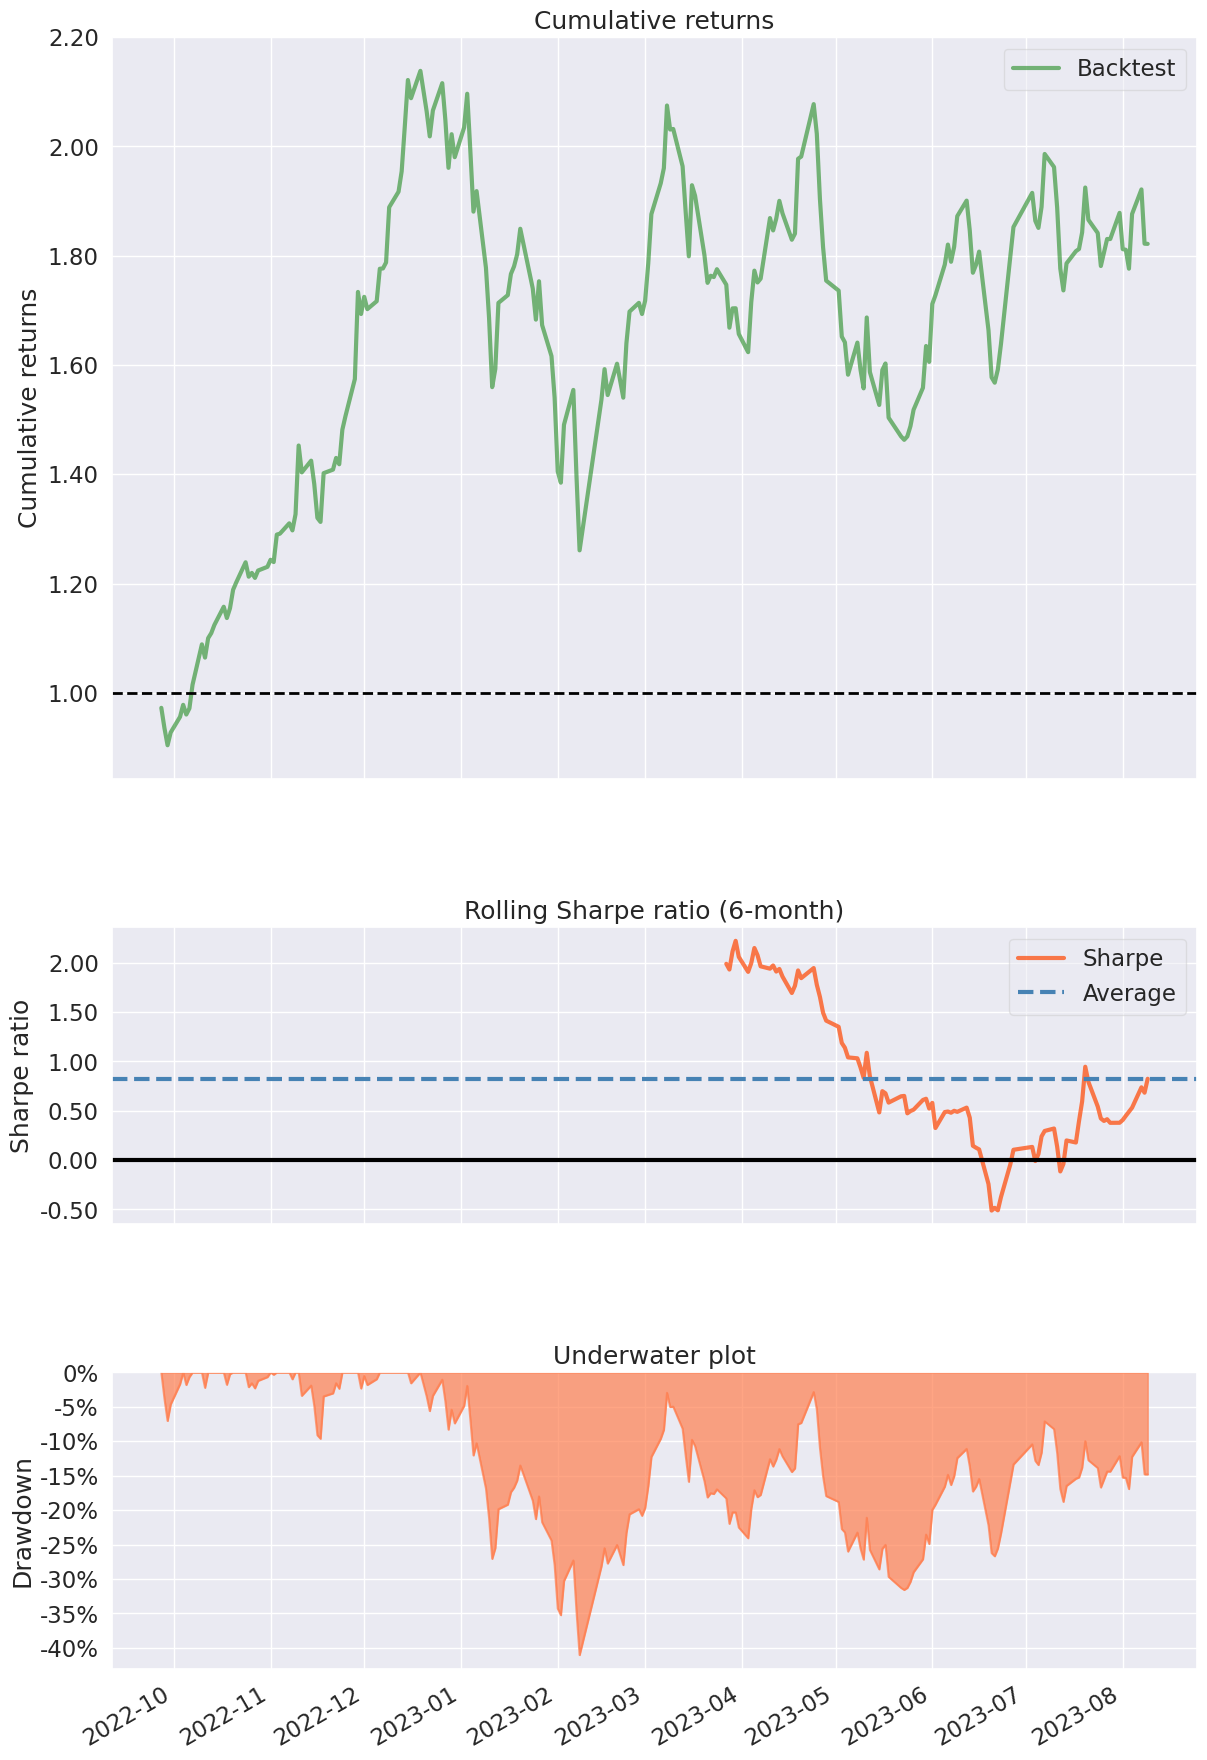

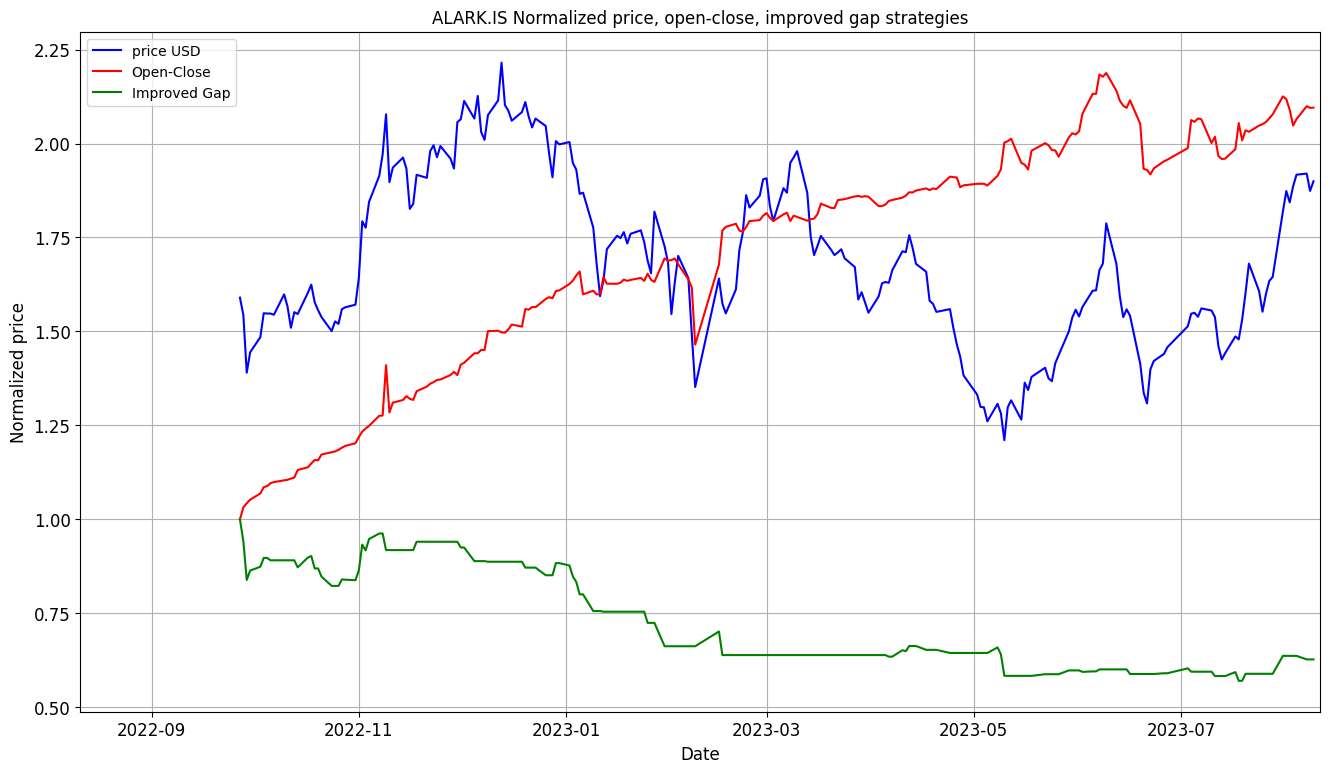


Creating Tear Sheet for ALARK.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for SMRTG.IS : 



Updating data for SMRTG.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for SMRTG.IS

Plotting Open-Close Performance for SMRTG.IS


<ipython-input-48-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


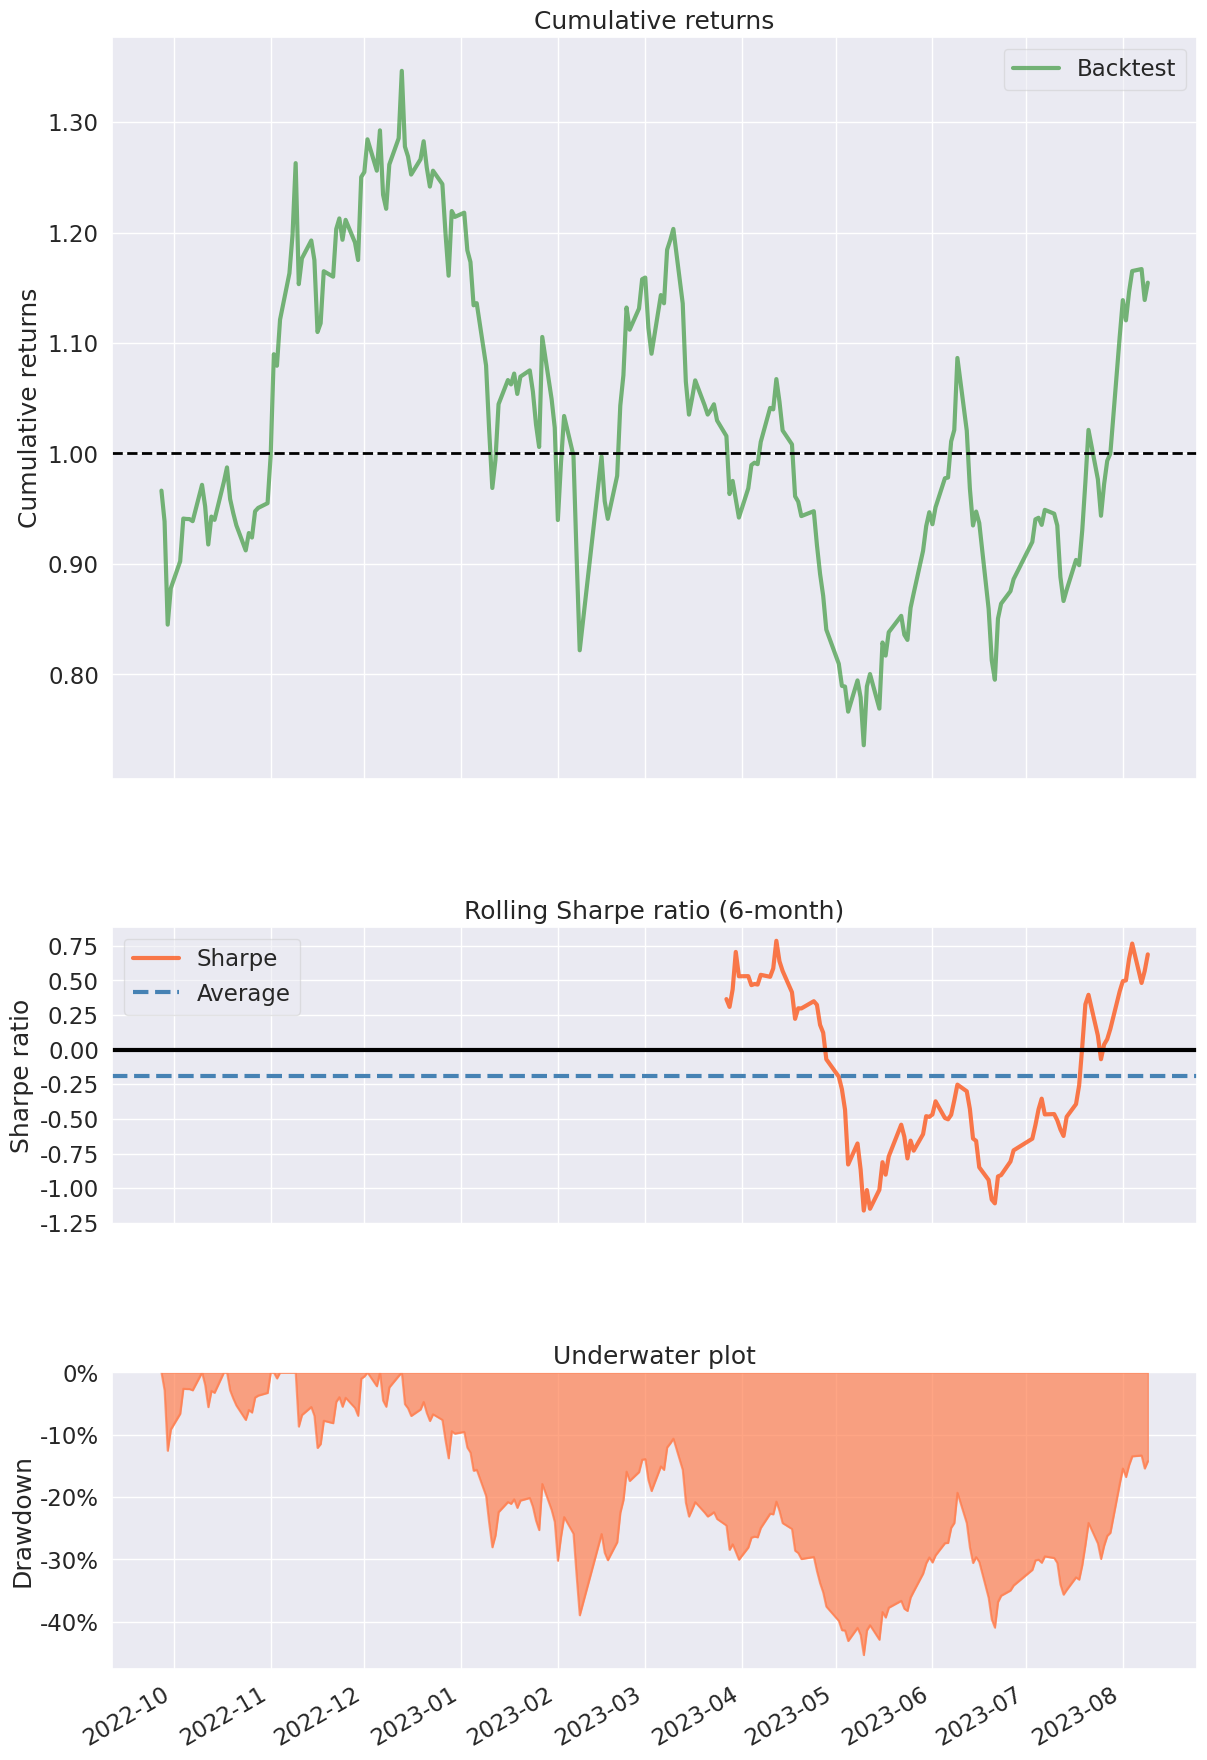

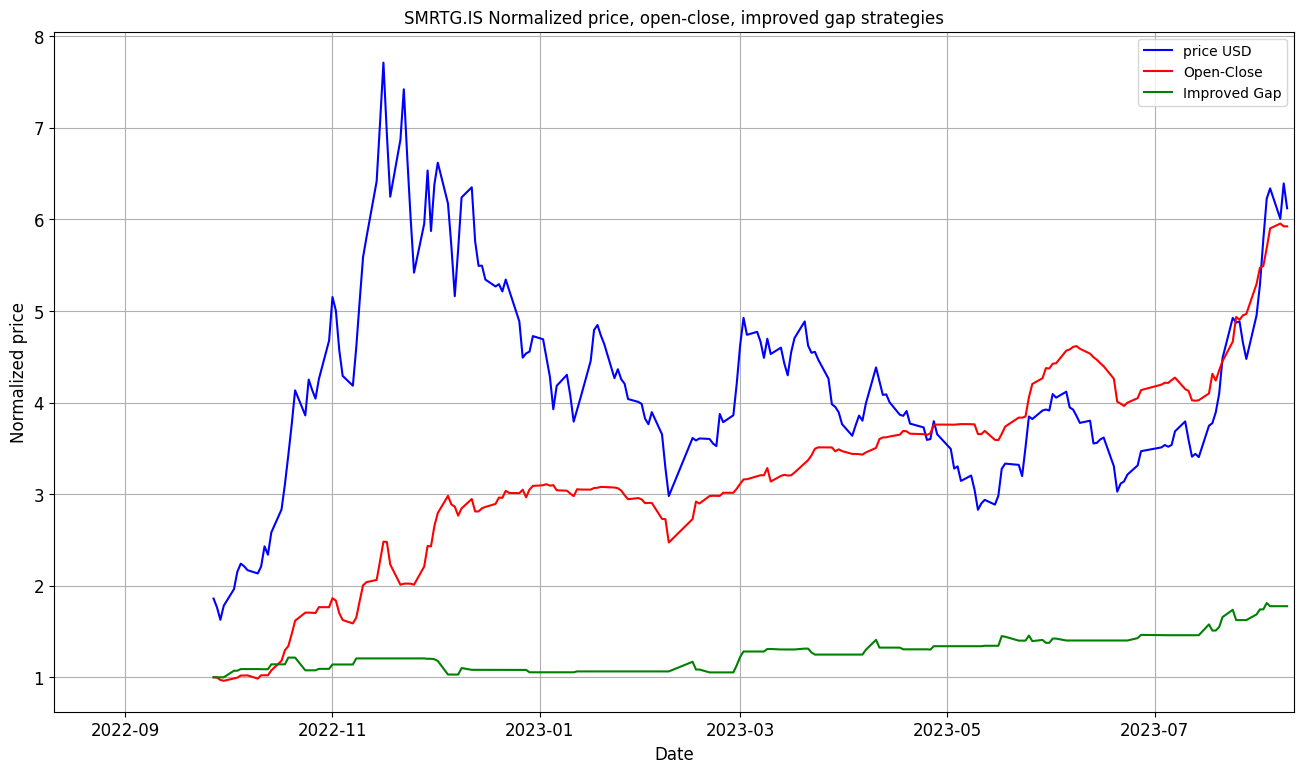


Creating Tear Sheet for SMRTG.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for KOZAA.IS : 



Updating data for KOZAA.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for KOZAA.IS

Plotting Open-Close Performance for KOZAA.IS


<ipython-input-48-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


In [ ]:
def main():

  target_return = 0

  bist30_df = ShowTRMarket(BIST30, target_return)
  for ticker in bist30_df['Ticker']:
    print("\n====================================================")
    print(f"\nShowing Ticker Stats for {ticker} : ")
    print("\n====================================================")
    ShowTickerStats( ticker,"BIST")

  bist100_df = ShowTRMarket(BIST100, target_return)
  for ticker in bist100_df['Ticker']:
    print("\n====================================================")
    print(f"\nShowing Ticker Stats for {ticker} : ")
    print("\n====================================================")
    ShowTickerStats( ticker,"BIST")

  dow_df = ShowUSMarket(DOW30, target_return)
  for ticker in dow_df['Ticker'].head(10):
    print("\n====================================================")
    print(f"\nShowing Ticker Stats for {ticker} : ")
    print("\n====================================================")
    ShowTickerStats( ticker,"DOW30")

  sp500_df = ShowUSMarket(sp500_constituents.Symbol, target_return)
  for ticker in sp500_df['Ticker']:
    print("\n====================================================")
    print(f"\nShowing Ticker Stats for {ticker} : ")
    print("\n====================================================")
    ShowTickerStats( ticker,"SP500")

  # #EmpyrialPortfolioPerformance()

  print(f"\nHere is our most probable winner list (for TR = {target_return}) :")
  print("\n====================================================")

  pd.set_option('display.max_columns', None)

  bist30_df = bist30_df.reset_index(drop=True)
  bist100_df = bist100_df.reset_index(drop=True)
  dow_df = dow_df.reset_index(drop=True)
  sp500_df = sp500_df.reset_index(drop=True)

  print(bist30_df)
  print(bist100_df)
  print(dow_df)
  print(sp500_df)

  # from google.colab import data_table
  # print(data_table.DataTable(bist_df, include_index=False, num_rows_per_page=10))

  cnt_PWin = len(bist30_df[(bist30_df['PWin'] > WINNER_LIMIT_TR)])
  cnt_PWin_OC = len(bist30_df[(bist30_df['PWin_OC'] > WINNER_LIMIT_TR)])
  print("\n====================================================")
  print("\n====================================================")
  print("\n====================================================")
  print("\n====================================================")
  print("\n====================================================")
  print(f"\nOut of {len(bist30_df['PWin'])}, there are {cnt_PWin} assets have Pwin > {WINNER_LIMIT_TR}")
  print(f"\nOut of {len(bist30_df['PWin_OC'])}, there are {cnt_PWin_OC} assets have PWin_OC > {WINNER_LIMIT_TR}")

  cnt_PWin = len(bist100_df[(bist100_df['PWin'] > WINNER_LIMIT_TR)])
  cnt_PWin_OC = len(bist100_df[(bist100_df['PWin_OC'] > WINNER_LIMIT_TR)])
  print("\n====================================================")
  print("\n====================================================")
  print("\n====================================================")
  print("\n====================================================")
  print("\n====================================================")
  print(f"\nOut of {len(bist100_df['PWin'])}, there are {cnt_PWin} assets have Pwin > {WINNER_LIMIT_TR}")
  print(f"\nOut of {len(bist100_df['PWin_OC'])}, there are {cnt_PWin_OC} assets have PWin_OC > {WINNER_LIMIT_TR}")

  cnt_PWin = len(dow_df[(dow_df['PWin'] > WINNER_LIMIT_US)])
  cnt_PWin_OC = len(dow_df[(dow_df['PWin_OC'] > WINNER_LIMIT_US)])
  print("\n====================================================")
  print("\n====================================================")
  print("\n====================================================")
  print("\n====================================================")
  print("\n====================================================")
  print(f"\nOut of {len(dow_df['PWin'])}, there are {cnt_PWin} assets have Pwin > {WINNER_LIMIT_US}")
  print(f"\nOut of {len(dow_df['PWin_OC'])}, there are {cnt_PWin_OC} assets have PWin_OC > {WINNER_LIMIT_US}")


  cnt_PWin = len(sp500_df[(sp500_df['PWin'] > WINNER_LIMIT_US)])
  cnt_PWin_OC = len(sp500_df[(sp500_df['PWin_OC'] > WINNER_LIMIT_US)])
  print("\n====================================================")
  print("\n====================================================")
  print("\n====================================================")
  print("\n====================================================")
  print("\n====================================================")
  print(f"\nOut of {len(sp500_df['PWin'])}, there are {cnt_PWin} assets have Pwin > {WINNER_LIMIT_US}")
  print(f"\nOut of {len(sp500_df['PWin_OC'])}, there are {cnt_PWin_OC} assets have PWin_OC > {WINNER_LIMIT_US}")


if __name__ == "__main__":
  main()